In [2]:
# Setup
import sys
import numpy as np
import tensorflow as tf
import Utils.PokemonUtils as pkmnUtils
from matplotlib import pyplot as plt
from Models import Baseline
import importlib

utils = pkmnUtils.PokemonUtils(rel_loc="")

# Only run if split file has not already been generated
if False:
    utils.loadAllGIFs()
    
utils.localLoadAllGifs("Data/SplitsV2.npz")
x_train, x_val, x_test, y_train, y_val, y_test = utils.getSplits()

USE_GPU = False
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
x_train: (6010, 128, 128, 4)
x_val:   (1510, 128, 128, 4)
x_test:  (1880, 128, 128, 4)
y_train: (6010,)
y_val:   (1510,)
y_test:  (1880,)


In [ ]:
# Run on PokemonUtils update
import Utils.PokemonUtils as pkmnUtils
importlib.reload(pkmnUtils)  # update import if PokemonUtils.py changes
utils = pkmnUtils.PokemonUtils(utils=utils)

In [34]:
x_train_m = x_train.astype('float32') 
x_val_m = x_val.astype('float32') 
x_test_m = x_test.astype('float32')
y_train_m = y_train
y_val_m = y_val
y_test_m = y_test

# Images (range 0-1 necessary for imshow)
x_train_i = (x_train_m) / 255
x_val_i   = (x_val_m)   / 255
x_test_i  = (x_test_m)  / 255

# Model
x_mean = np.mean(x_train_m)
x_train_m = (x_train_m - x_mean) / 255
x_val_m   = (x_val_m - x_mean)   / 255
x_test_m  = (x_test_m - x_mean)  / 255

# Small (1 frame per pokemon)
x_train_s = x_train_m[::10]
x_val_s   = x_val_m[::10]
x_test_s  = x_test_m[::10]
y_train_s = y_train_m[::10]
y_val_s   = y_val_m[::10]
y_test_s  = y_test_m[::10]

# Downsampled (5 frames per pokemon, 64x64)
x_train_d = x_train_m[::2,::2,::2,:]
x_val_d   = x_val_m[::2,::2,::2,:]
x_test_d  = x_test_m[::2,::2,::2,:]
y_train_d = y_train_m[::2]
y_val_d   = y_val_m[::2]
y_test_d  = y_test_m[::2]

print("Data normalization:")
print("mean:", x_mean)
print("max: ", np.max(x_train_m))
print("min: ", np.min(x_train_m))
print("Data shapes:")
print("x_train_m:", x_train_m.shape)
print("x_val_m:  ", x_val_m.shape)
print("x_test_m: ", x_test_m.shape)
print("y_train_m:", y_train_m.shape)
print("y_val_m:  ", y_val_m.shape)
print("y_test_m: ", y_test_m.shape)
print("x_train_s:", x_train_s.shape)
print("x_val_s:  ", x_val_s.shape)
print("x_test_s: ", x_test_s.shape)
print("y_train_s:", y_train_s.shape)
print("y_val_s:  ", y_val_s.shape)
print("y_test_s: ", y_test_s.shape)
print("x_train_d:", x_train_d.shape)
print("x_val_d:  ", x_val_d.shape)
print("x_test_d: ", x_test_d.shape)
print("y_train_d:", y_train_d.shape)
print("y_val_d:  ", y_val_d.shape)
print("y_test_d: ", y_test_d.shape)

Data normalization:
mean: 26.632238
max:  0.89555985
min:  -0.10444015
Data shapes:
x_train_m: (6010, 128, 128, 4)
x_val_m:   (1510, 128, 128, 4)
x_test_m:  (1880, 128, 128, 4)
y_train_m: (6010,)
y_val_m:   (1510,)
y_test_m:  (1880,)
x_train_s: (601, 128, 128, 4)
x_val_s:   (151, 128, 128, 4)
x_test_s:  (188, 128, 128, 4)
y_train_s: (601,)
y_val_s:   (151,)
y_test_s:  (188,)
x_train_d: (3005, 64, 64, 4)
x_val_d:   (755, 64, 64, 4)
x_test_d:  (940, 64, 64, 4)
y_train_d: (3005,)
y_val_d:   (755,)
y_test_d:  (940,)


Using TensorFlow backend.


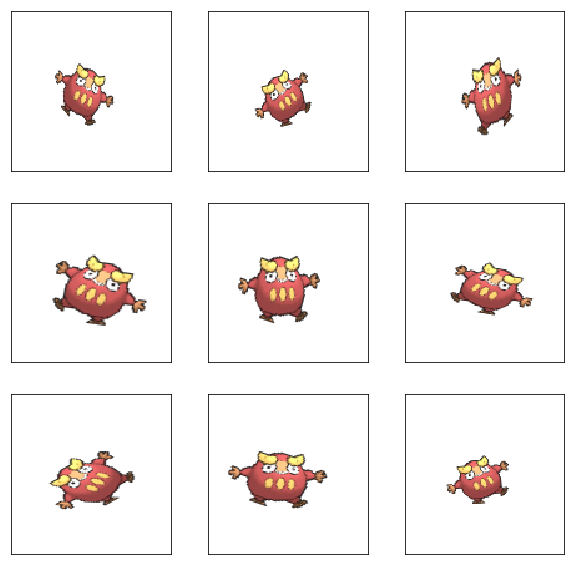

In [4]:
# Functions / objects necessary to train a model
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import skimage.color as color

def oneHot(y, cols=None):
    if (cols < 1):
        cols = np.max(y)
    n = y.shape[0]
    z = np.zeros((n, cols))
    z[np.arange(n), (y-1)] = 1
    return z


data_aug = ImageDataGenerator(
    rotation_range=50,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

image = x_train_i[0,:,:,:]
image = image.reshape((1,) + image.shape)

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,3)

i = 0
for batch in data_aug.flow(image, batch_size=1):
    ax = plt.subplot(gs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(batch[0])
    i += 1
    if i >= 9:
        break

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint

use_baseline = False
model = None

def getInitialModel(use_baseline, reg=0, drop=0.5, downsample=1):
    if use_baseline:
        model = Sequential([
                Conv2D(32, (5, 5), input_shape=(128,128,4)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Conv2D(64, (5, 5)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Flatten(),

                Dense(64),
                Activation("relu"),
                Dense(18),
                Activation("softmax")
            ])
    else:
        print("Model params: drop =", drop, ", reg =", reg)
        model = Sequential([
                Conv2D(32, (5, 5), input_shape=(128//downsample,128//downsample,4), padding='same', kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Conv2D(64, (5, 5), padding='same', kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Flatten(),

                Dense(64, kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                Dropout(drop),
                Dense(18, kernel_regularizer=regularizers.l2(reg)),
                Activation("softmax")
            ])
    return model
  
model = getInitialModel(False, reg=.008, drop=.15)

Model params: drop = 0.15 , reg = 0.008


In [48]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
# Training
filepath = "./Models/neuralmon_model_5.hdf5"
batch_size = 64
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(
    data_aug.flow(x_train_m, oneHot(y_train_m, 18), batch_size=batch_size),
    epochs=30,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=(x_val_m, oneHot(y_val_m, 18)),
)
model.save("./Models/neuralmon_model_5_final.hdf5")

Epoch 1/30
94/94 [==============================] - 187s 2s/step - loss: 3.5696 - acc: 0.1199 - val_loss: 3.1588 - val_acc: 0.1258

Epoch 00001: val_acc improved from -inf to 0.12583, saving model to ./Models/neuralmon_model_5.hdf5
Epoch 2/30
94/94 [==============================] - 184s 2s/step - loss: 3.0157 - acc: 0.1379 - val_loss: 3.0305 - val_acc: 0.1079

Epoch 00002: val_acc did not improve
Epoch 3/30
94/94 [==============================] - 185s 2s/step - loss: 2.8044 - acc: 0.1825 - val_loss: 2.8833 - val_acc: 0.1636

Epoch 00003: val_acc improved from 0.12583 to 0.16358, saving model to ./Models/neuralmon_model_5.hdf5
Epoch 4/30
94/94 [==============================] - 185s 2s/step - loss: 2.6759 - acc: 0.2056 - val_loss: 2.8624 - val_acc: 0.1623

Epoch 00004: val_acc did not improve
Epoch 5/30
94/94 [==============================] - 184s 2s/step - loss: 2.6093 - acc: 0.2193 - val_loss: 2.8748 - val_acc: 0.1497

Epoch 00005: val_acc did not improve
Epoch 6/30
94/94 [========

In [46]:
# history2 = model.fit_generator(
#     data_aug.flow(x_train_m, oneHot(y_train_m, 18), batch_size=batch_size),
#     epochs=20,
#     verbose=1,
#     validation_data=(x_val_m, oneHot(y_val_m, 18)),
#     steps_per_epoch=x_train_m.shape[0] // batch_size * aug_factor,
#     initial_epoch = 15
# )
# model.save("./Models/neuralmon_model_2.2.hdf5")

In [78]:
from keras.models import load_model
# model.load_weights("./Models/neuralmon_model_2.hdf5")
model = load_model("./Models/neuralmon_model_5.hdf5")

In [50]:
h = {}
h = history.history
# for k in history.history.keys():
#     h[k] = history.history[k] + history2.history[k]

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


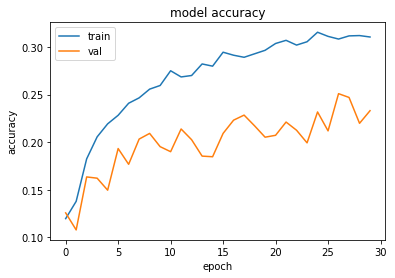

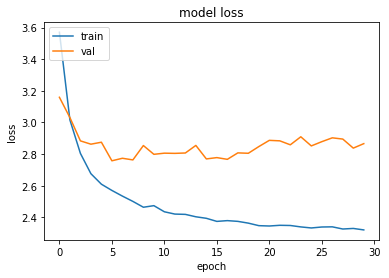

In [51]:
# list all data in history
print(h.keys())

# summarize history for accuracy
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
pred_train_m = model.predict(x_train_m)
print('Done!')
pred_val_m = model.predict(x_val_m)
print('Done!')
pred_test_m = model.predict(x_test_m)
print('Done!')

Done!
Done!
Done


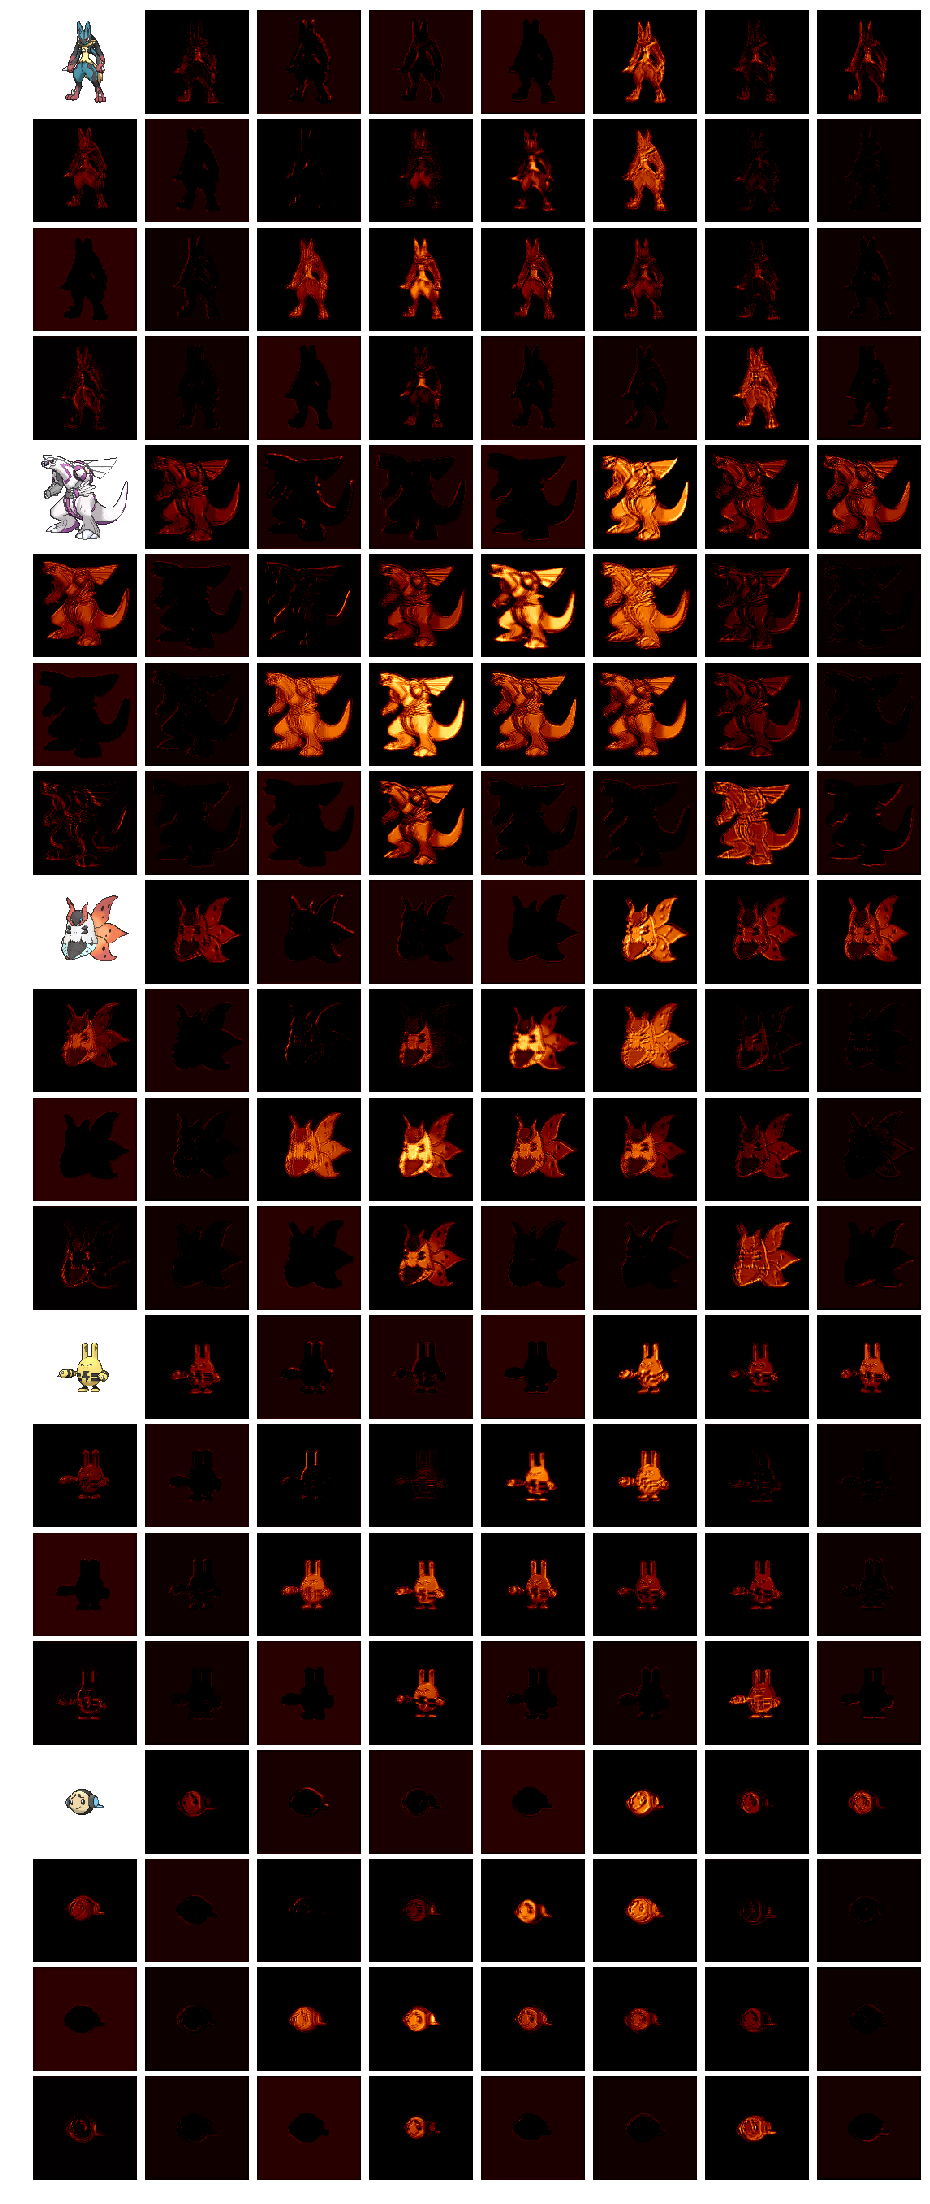

In [54]:
# we build a new model with the activations of the old model
# this model is truncated after the first layer
model_trunc = Sequential([
    Conv2D(32, (5, 5), input_shape=(128,128,4), padding='same', kernel_regularizer=regularizers.l2(0.008)),
    Activation("relu"),
])

start = 0
num = 50
step = 10

plt.figure(figsize=(16,8*num))
gs = gridspec.GridSpec(num*4,8)
gs.update(wspace=0.025, hspace=0.05)

idx = 0
for j in range(start, start+num, step):
    activations = model_trunc.predict(x_val_m[j].reshape(1,128,128,4))
    for i in range(0,32):        
        layer_filter = activations.reshape([128,128,32])[:,:,i]
        ax = plt.subplot(gs[32*idx+i])
        plt.axis("off")  
        if i == 0:
            plt.imshow(x_val_i[j])
        else:
            plt.imshow(layer_filter,cmap="afmhot",vmin=0, vmax=1)
    idx += 1

In [56]:
# Get secondary typing 
y_train_2, y_val_2, y_test_2 = utils.getSecondaryTypeLabels()

y_train_2: (6010,)
y_val_2:   (1510,)
y_test_2:  (1880,)


In [57]:
# Averages scores across frames of pokemon's animation
def customPredict(scores, y, y2=None, frames=10):
    # Averaging
    N, T = scores.shape
    scores_reshaped = scores.reshape((N//10, 10, T))
    avg_scores = np.mean(scores_reshaped, axis=1)
    
    # Primary accuracy
    predictions = np.argmax(avg_scores, axis=1)
    matches = predictions == y-1  # y is 1-indexed
    acc1 = np.sum(matches)/len(matches)
    
    acc2 = None
    if not y2 is None:
        matches2 = predictions == y2-1
        acc2 = np.sum(matches + matches2)/len(matches)  # + acts as an or operator
    
    # Dual accuracy
    return (acc1, acc2, avg_scores)
    

train_acc, train_acc_2, train_avg_scores = customPredict(pred_train_m, y_train_m[::10], y2=y_train_2[::10])
val_acc, val_acc_2, val_avg_scores = customPredict(pred_val_m, y_val_m[::10], y2=y_val_2[::10])
test_acc, test_acc_2, test_avg_scores = customPredict(pred_test_m, y_test_m[::10], y2=y_test_2[::10])
print("Train accuracy primary:       ", train_acc)
print("Train accuracy secondary:     ", train_acc_2)
print("Validation accuracy primary:  ", val_acc)
print("Validation accuracy secondary:", val_acc_2)
print("Test accuracy primary:        ", test_acc)
print("Test accuracy secondary:      ", test_acc_2)

Train accuracy primary:        0.37437603993344426
Train accuracy secondary:      0.39767054908485855
Validation accuracy primary:   0.23841059602649006
Validation accuracy secondary: 0.2781456953642384
Test accuracy primary:         0.24468085106382978
Test accuracy secondary:       0.28191489361702127


In [58]:
import Utils.PokemonPlot as pp
importlib.reload(pp)  # update import for changes

<module 'Utils.PokemonPlot' from '/home/zack/pokemon-learning/Utils/PokemonPlot.py'>

Train predictions


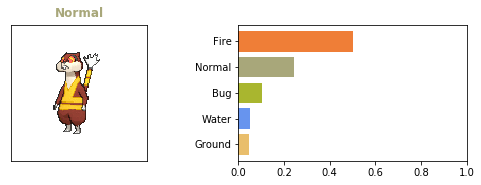

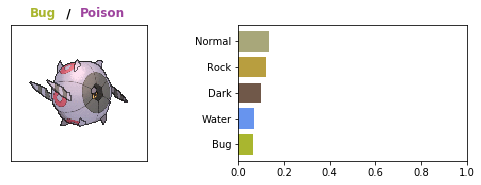

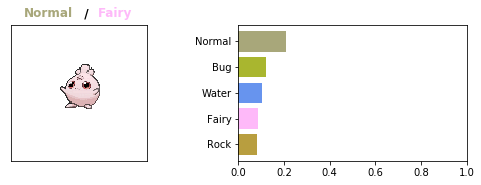

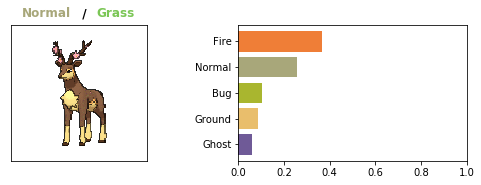

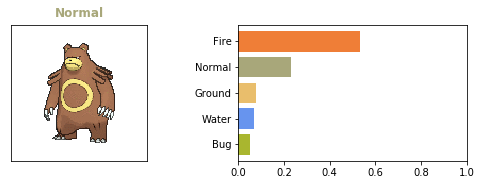

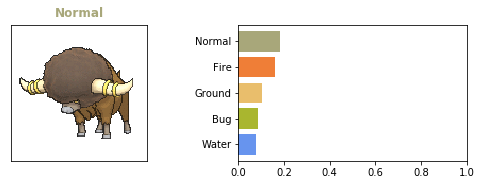

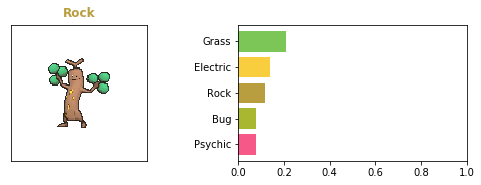

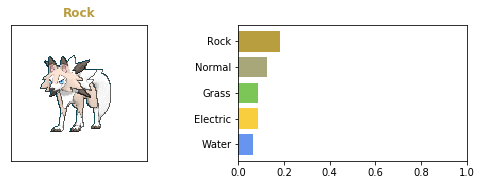

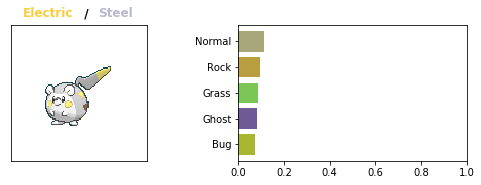

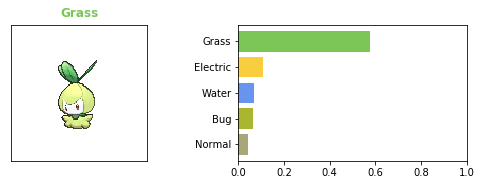

In [59]:
start = 100  # start index
num = 10    # number of images to display
step = 10  # number of frames / pokemon animation

print("Train predictions")
pp.plotPredictions(x_train_i[start*step:(start+num)*step:step],
                   y_train_m[start*step:(start+num)*step:step],
                   train_avg_scores[start:start+num:1], k=5, y2=y_train_2[start*step:(start+num)*step:step])

Validation predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


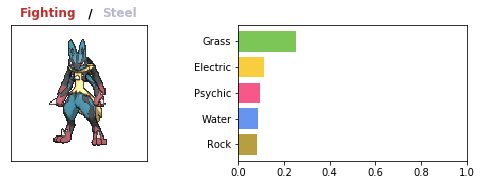

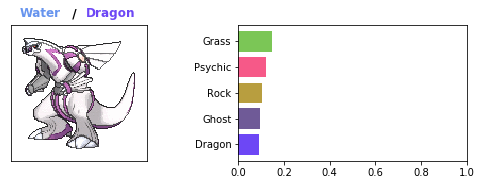

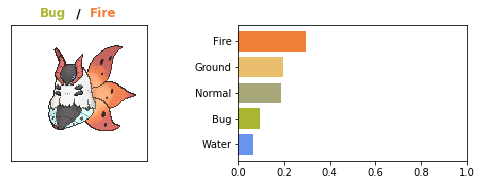

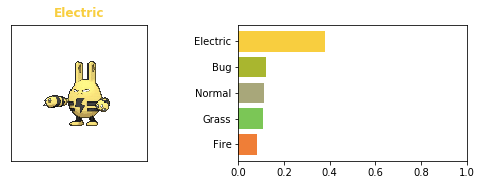

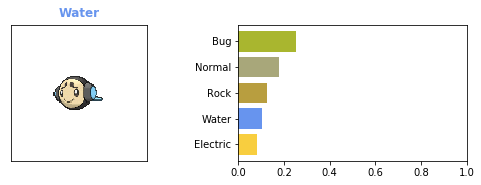

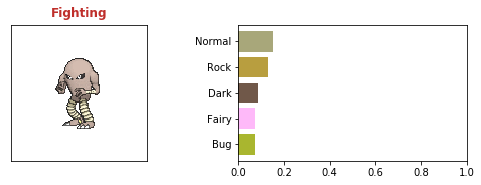

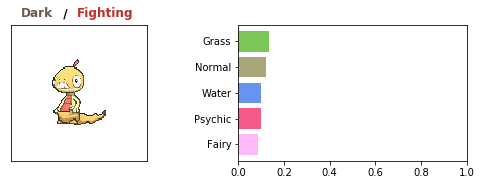

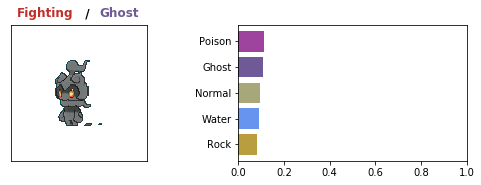

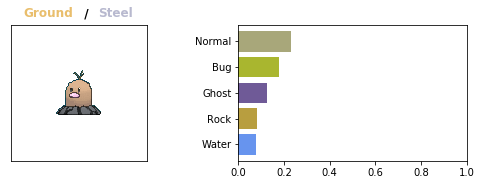

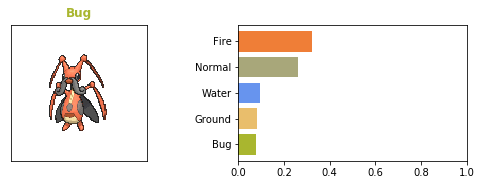

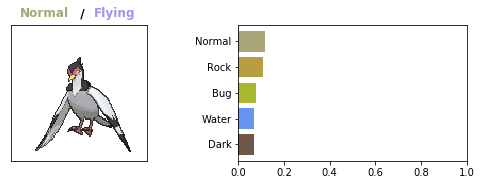

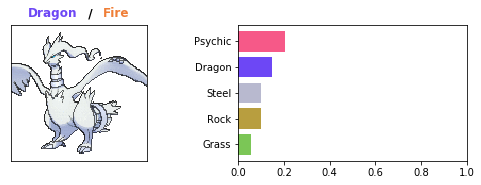

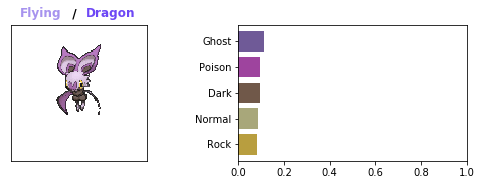

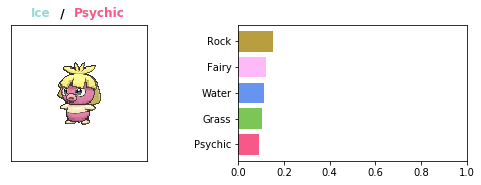

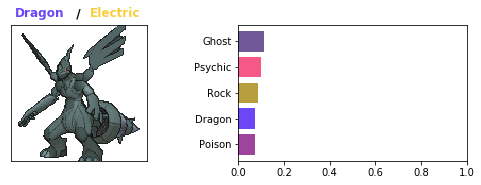

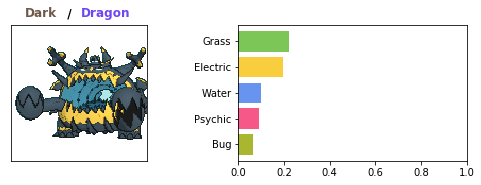

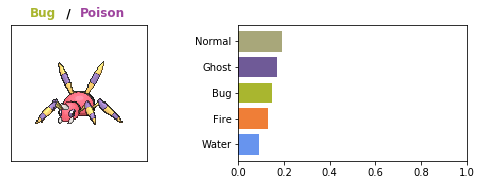

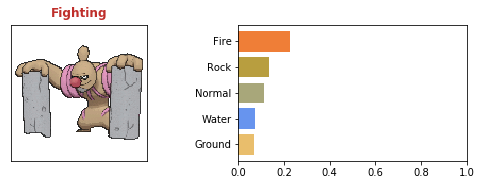

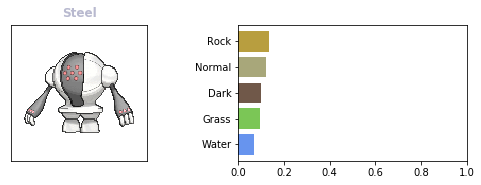

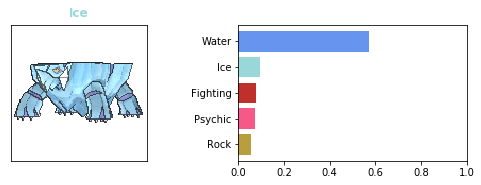

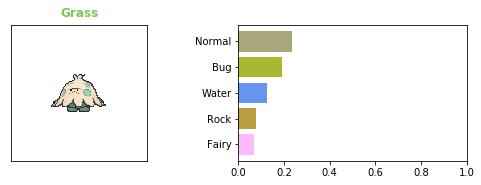

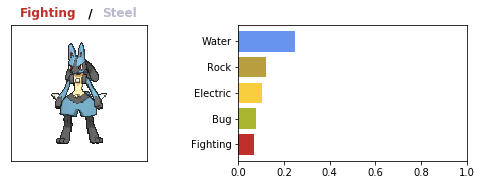

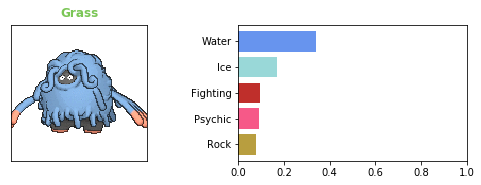

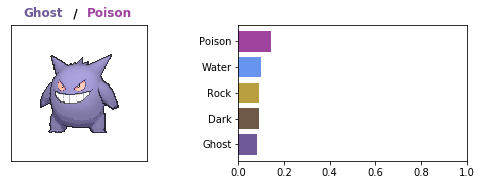

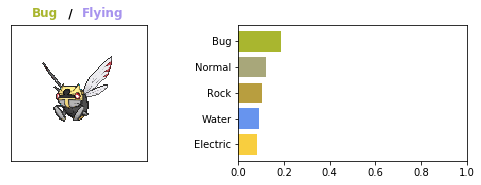

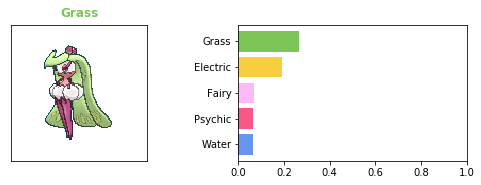

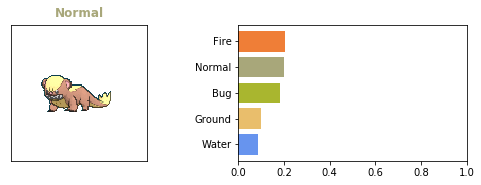

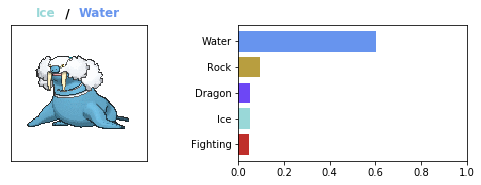

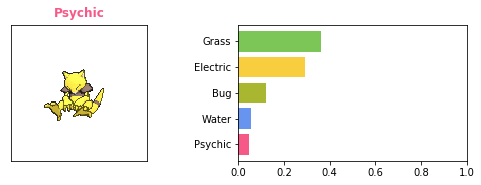

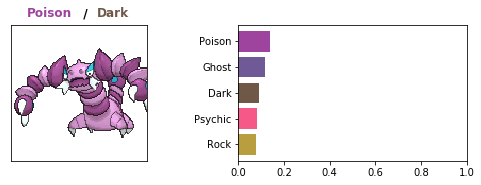

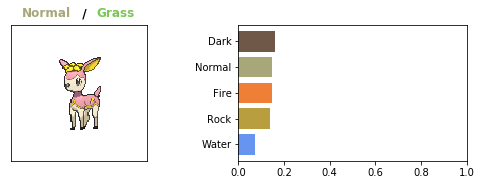

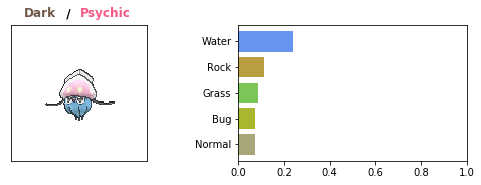

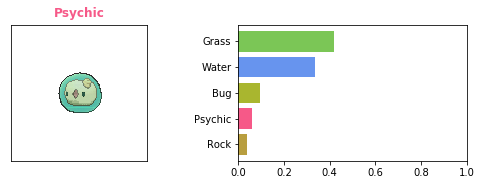

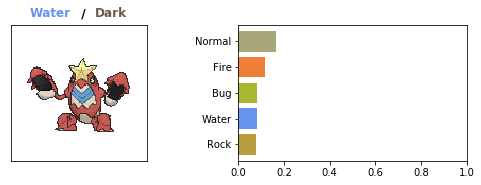

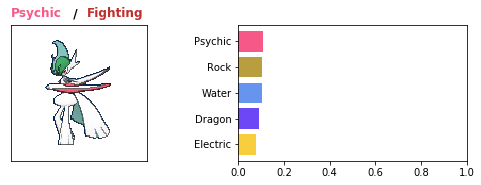

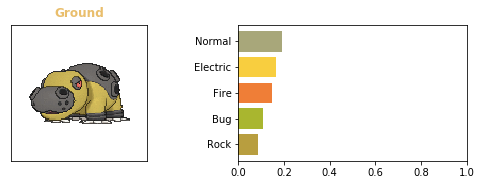

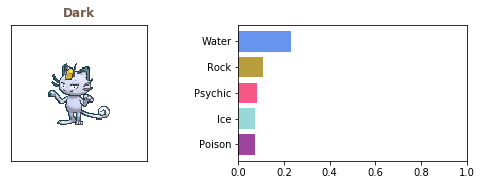

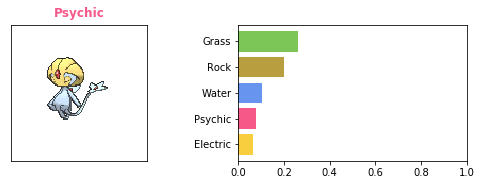

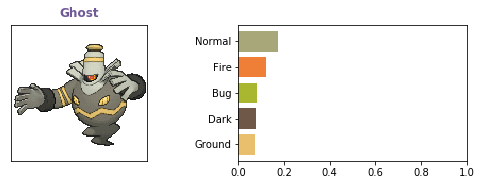

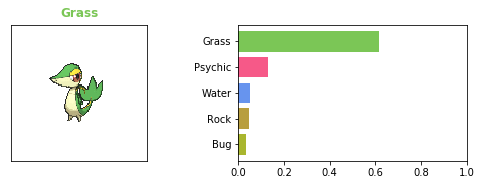

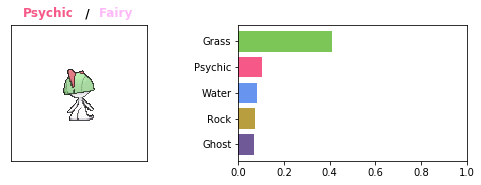

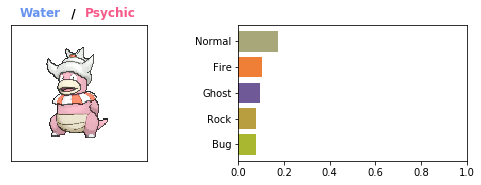

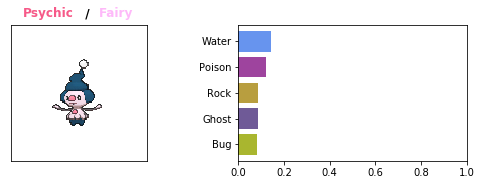

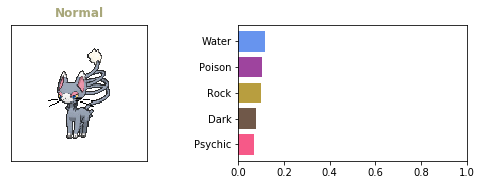

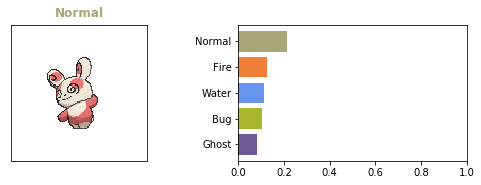

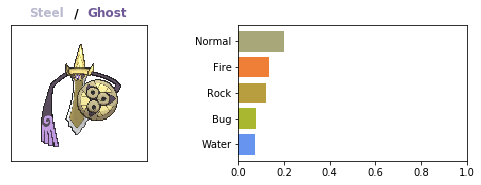

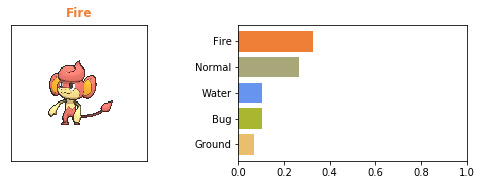

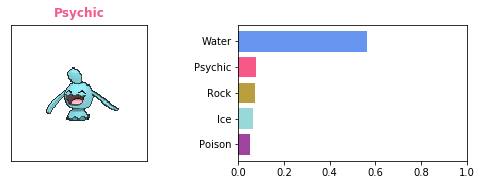

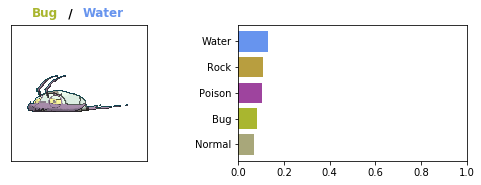

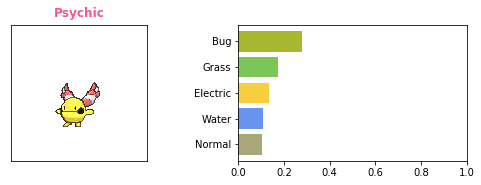

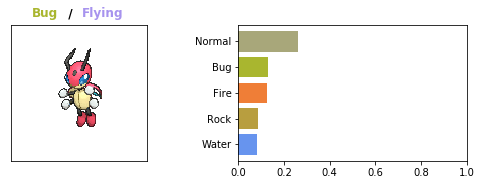

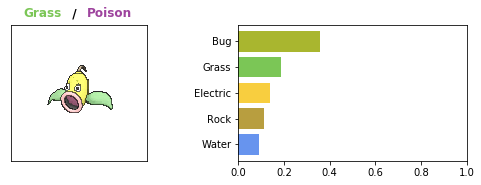

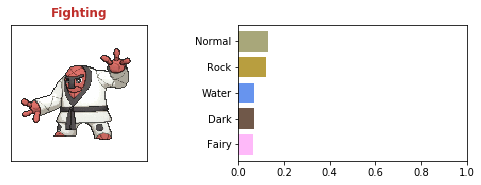

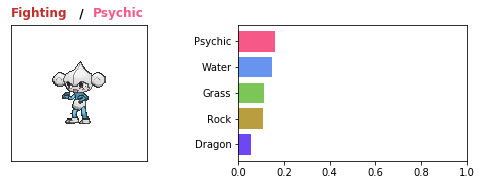

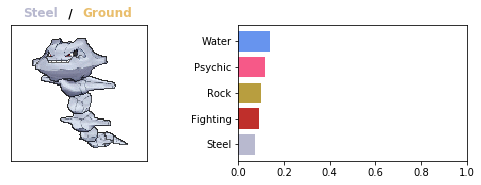

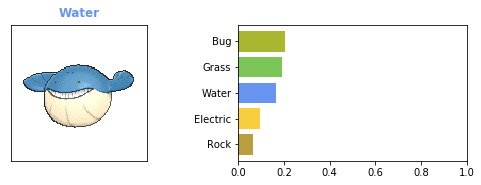

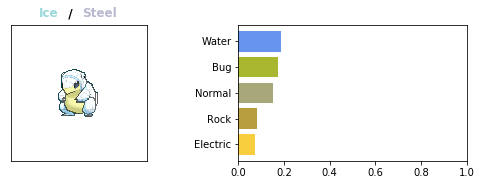

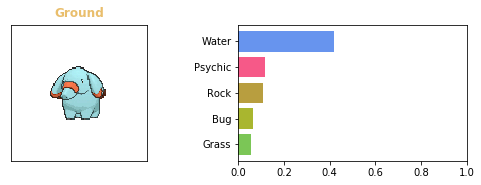

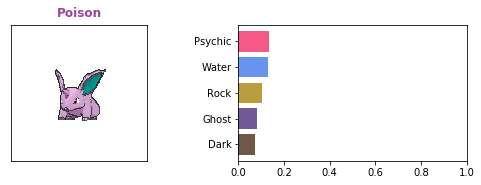

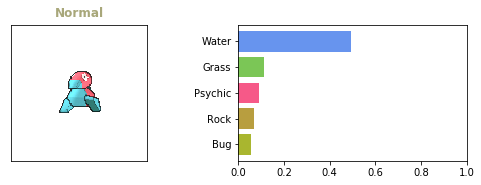

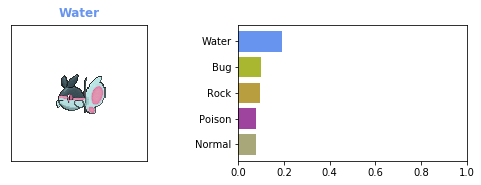

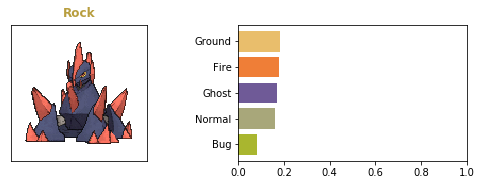

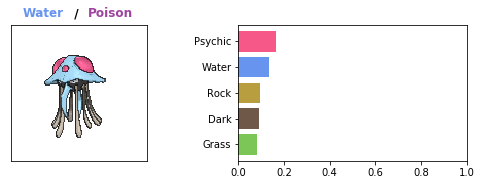

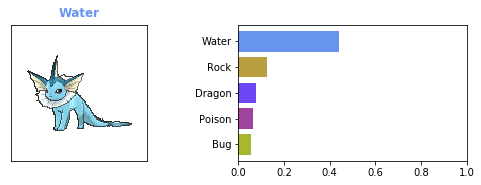

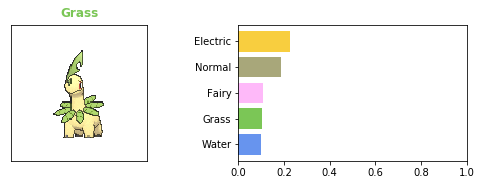

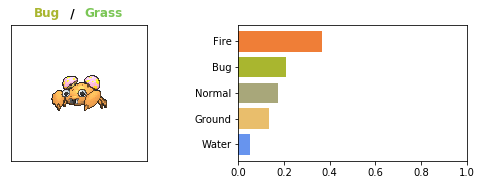

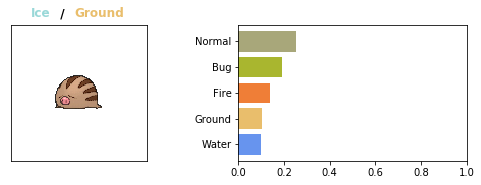

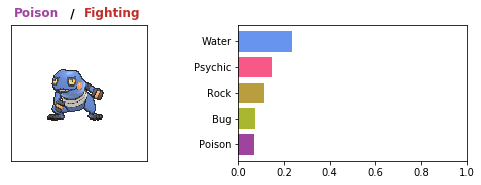

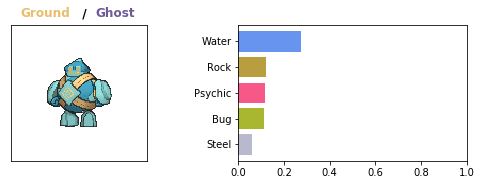

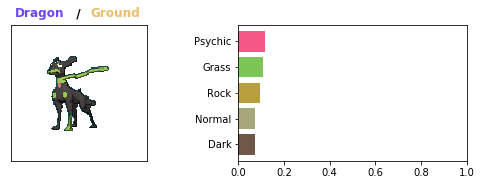

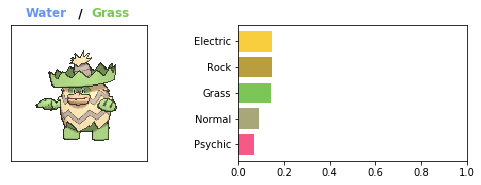

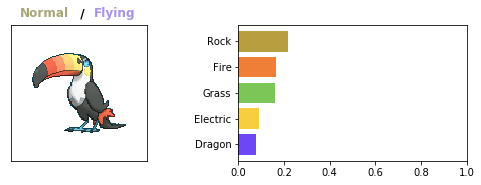

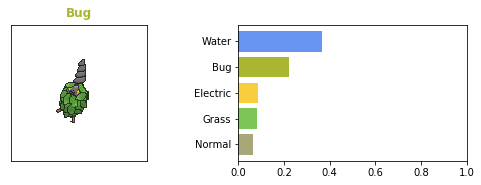

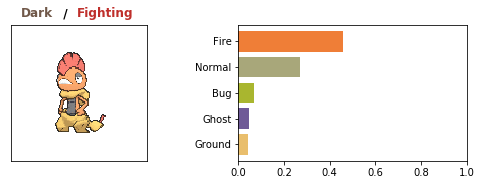

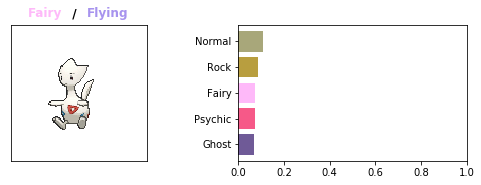

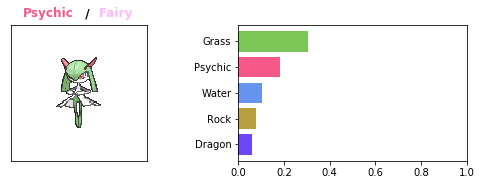

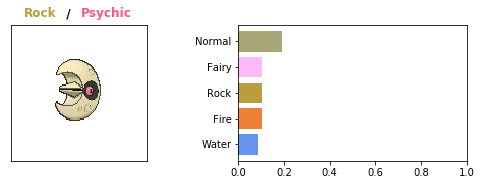

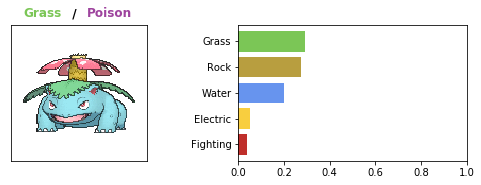

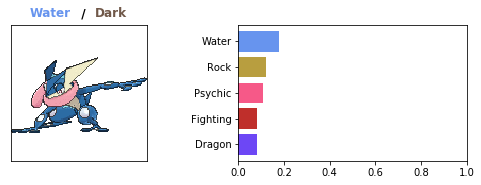

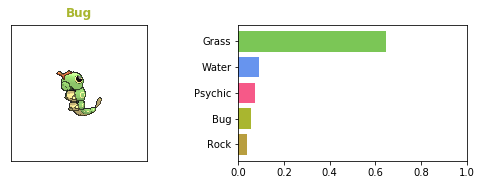

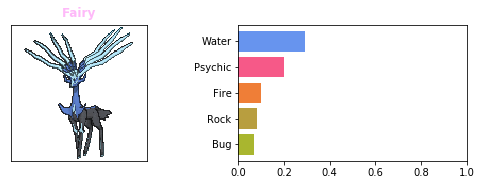

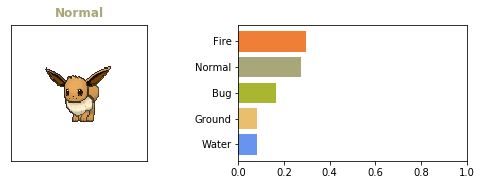

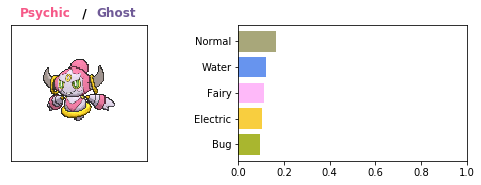

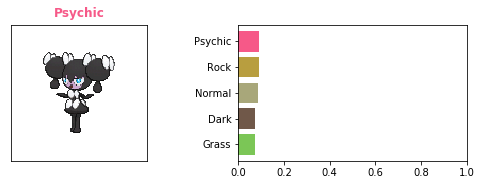

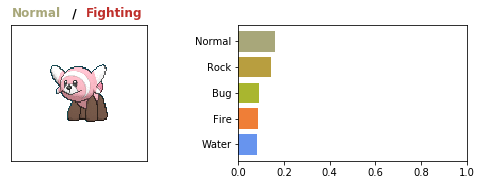

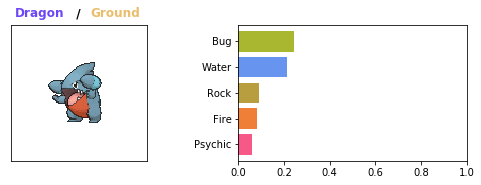

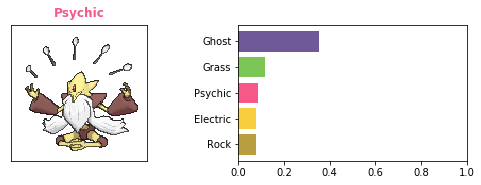

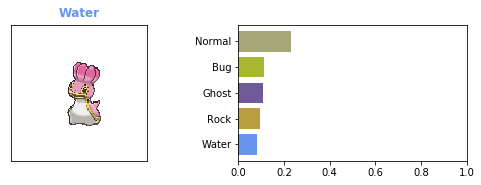

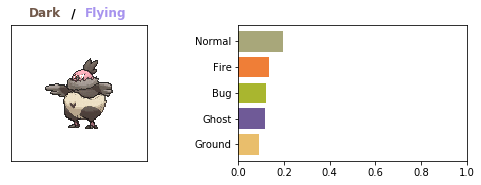

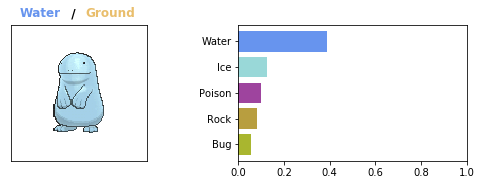

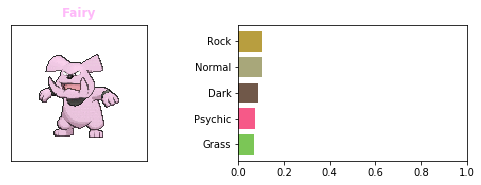

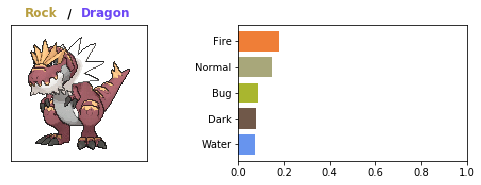

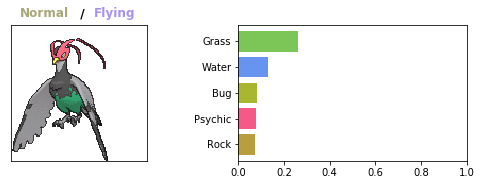

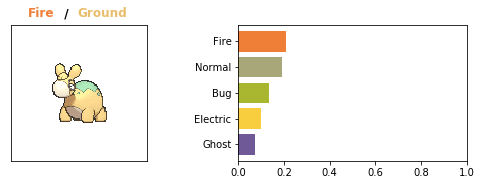

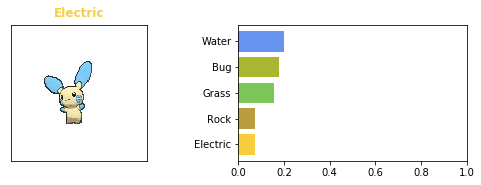

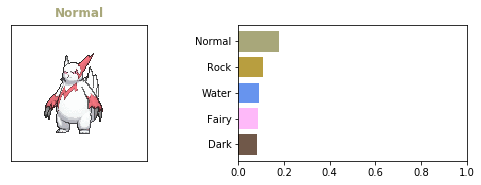

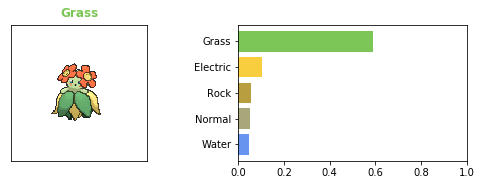

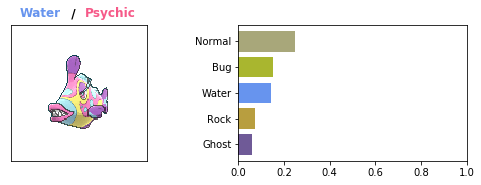

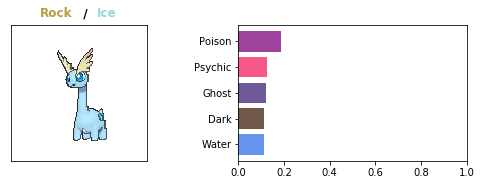

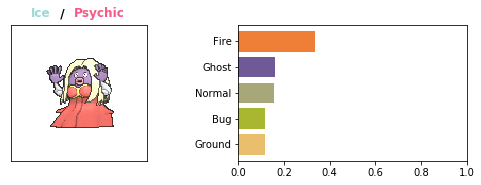

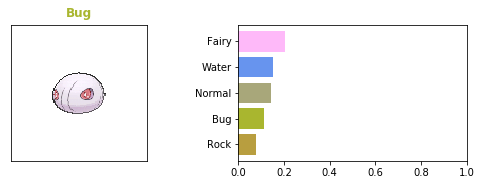

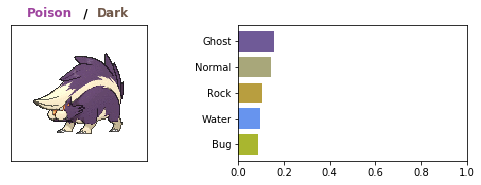

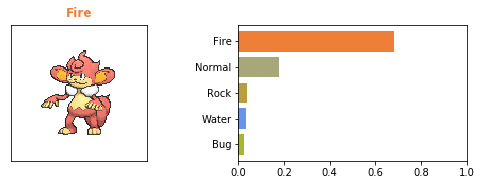

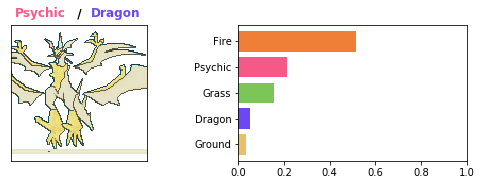

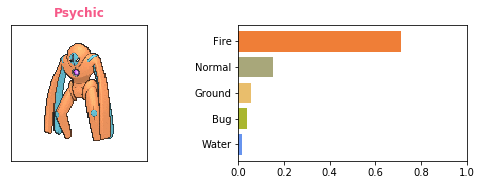

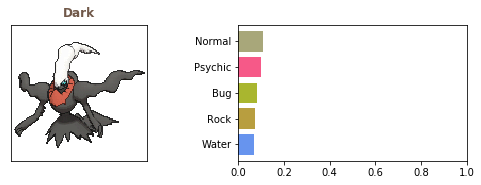

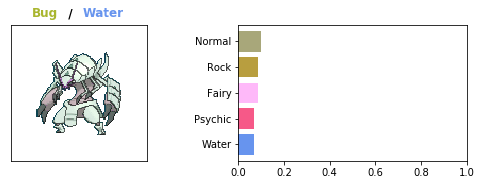

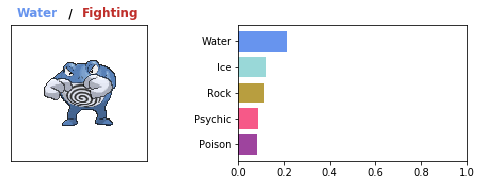

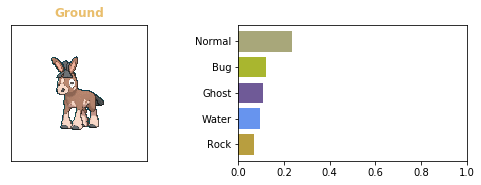

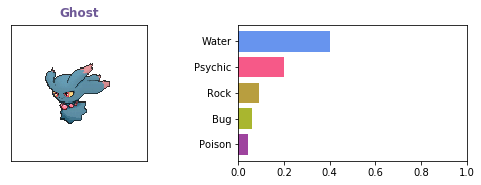

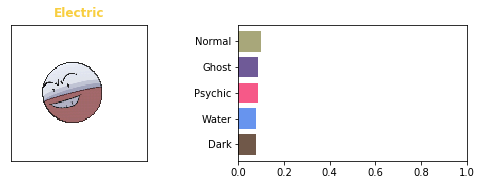

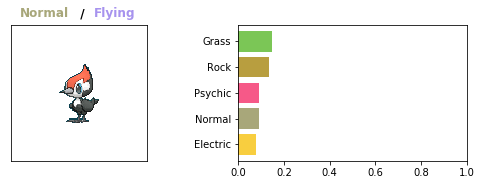

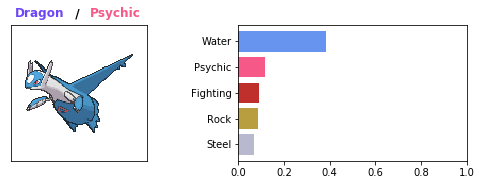

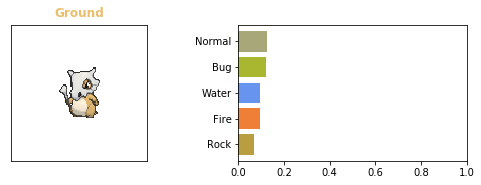

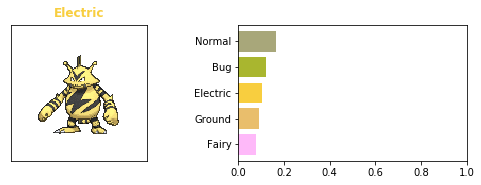

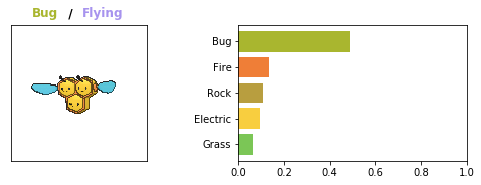

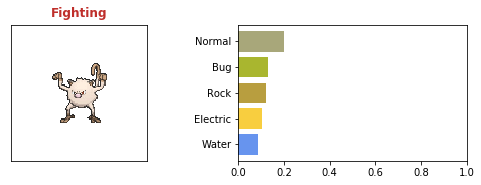

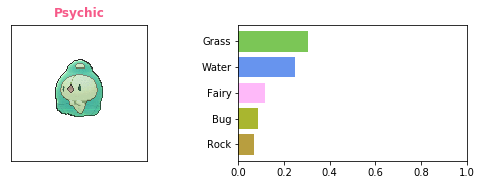

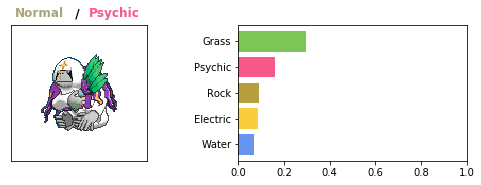

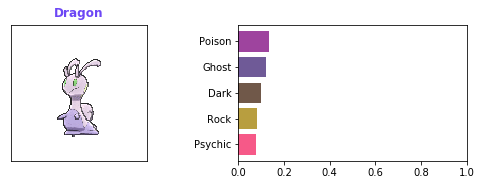

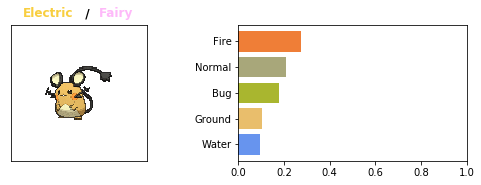

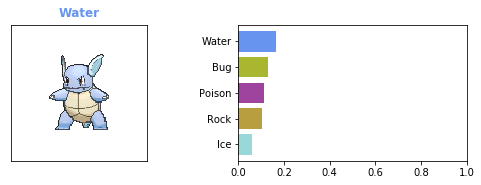

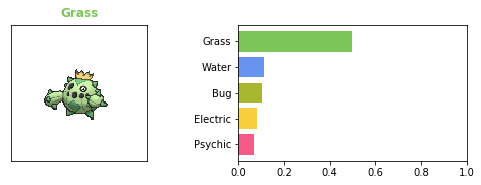

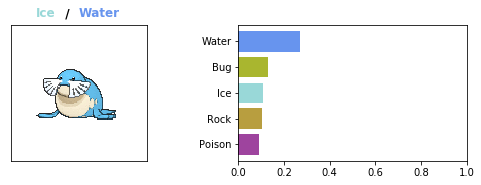

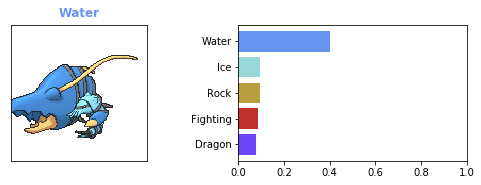

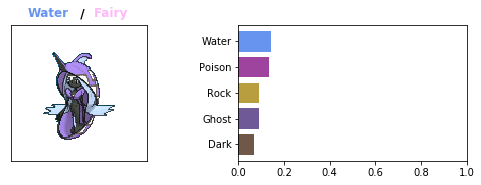

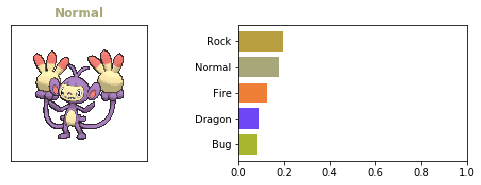

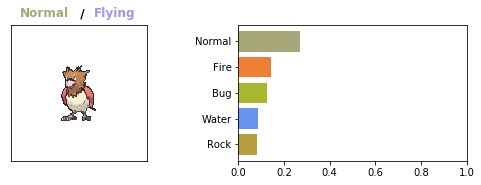

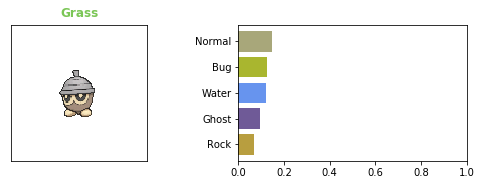

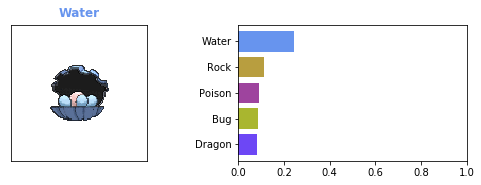

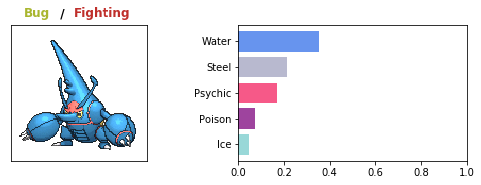

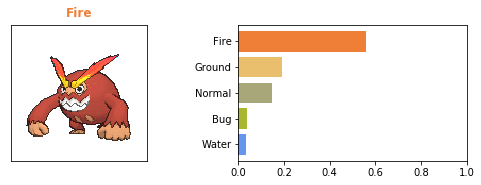

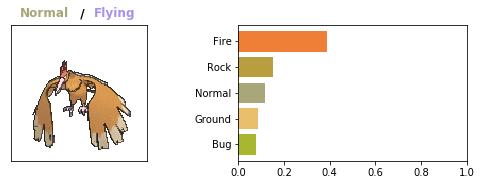

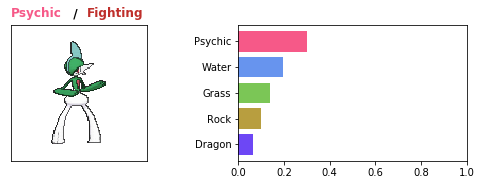

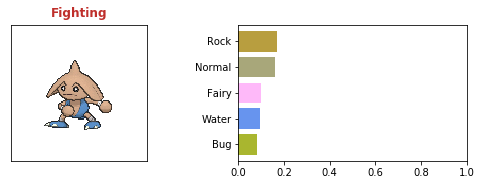

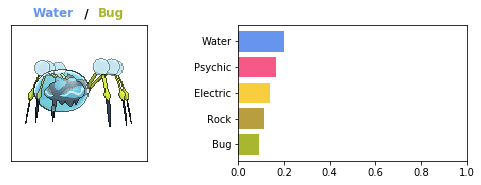

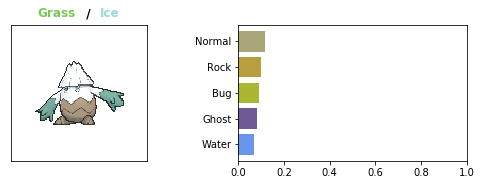

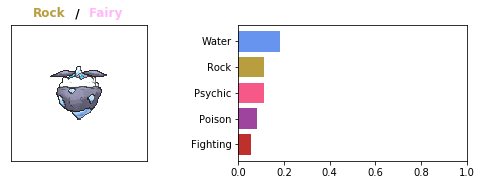

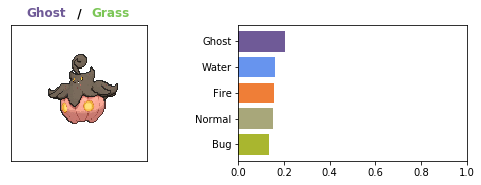

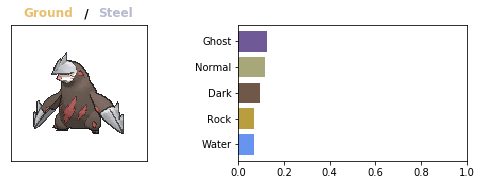

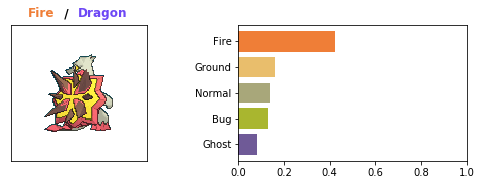

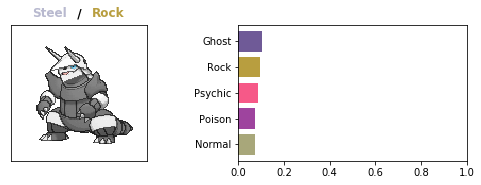

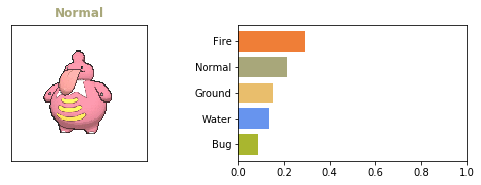

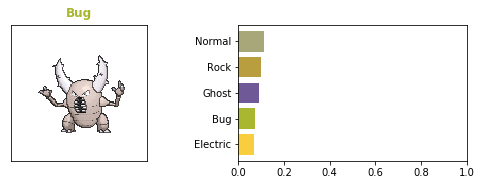

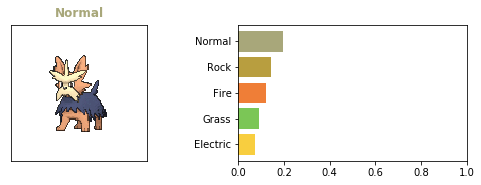

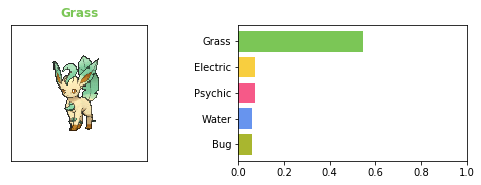

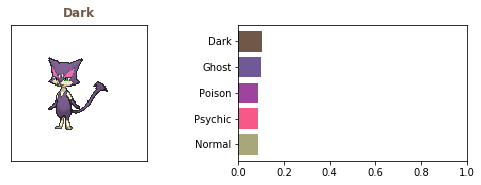

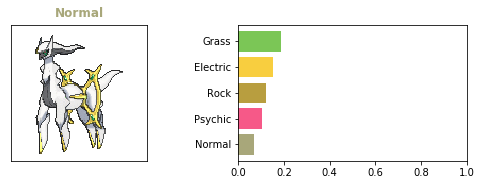

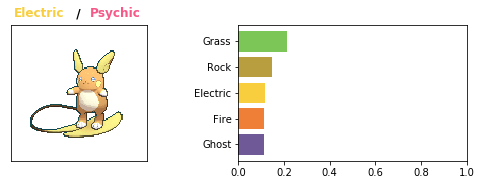

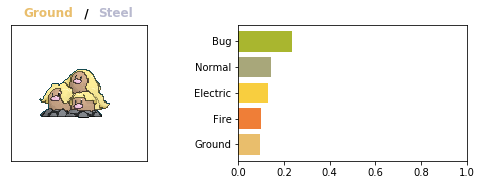

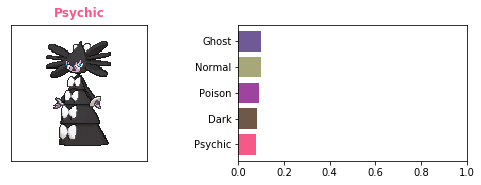

In [60]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Validation predictions")
pp.plotPredictions(x_val_i[start*step:(start+num)*step:step],
                   y_val_m[start*step:(start+num)*step:step],
                   val_avg_scores[start:start+num:1], k=5, y2=y_val_2[start*step:(start+num)*step:step])

Test predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


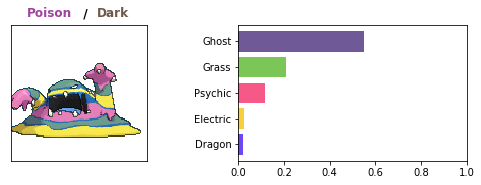

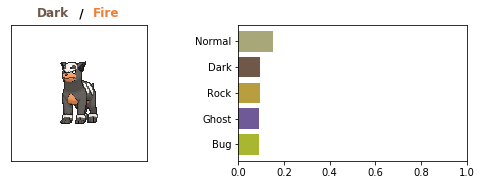

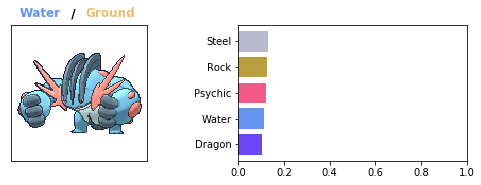

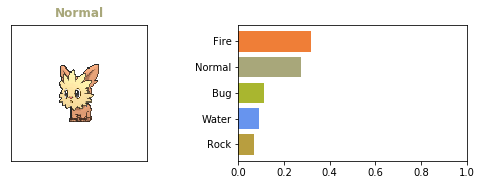

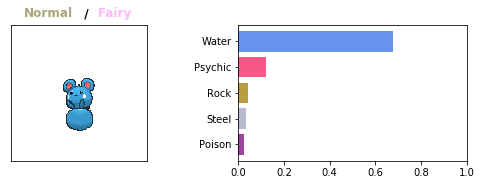

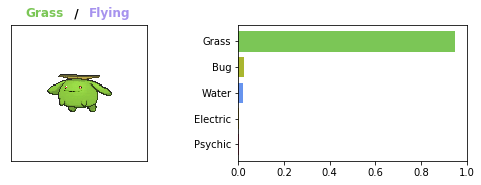

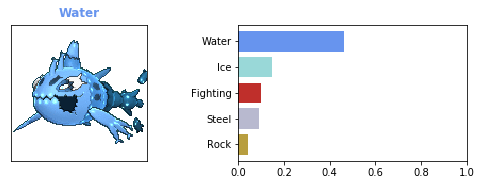

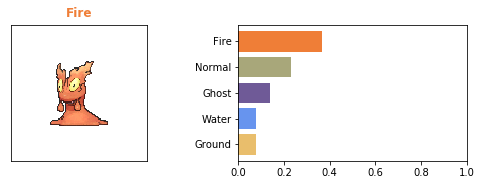

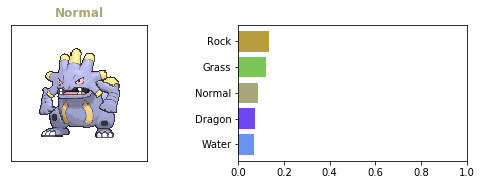

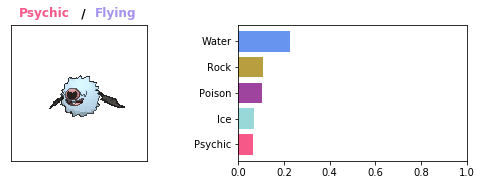

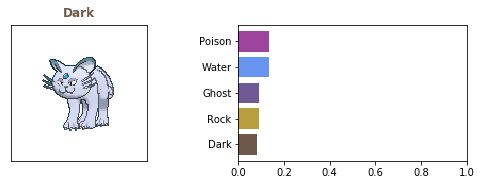

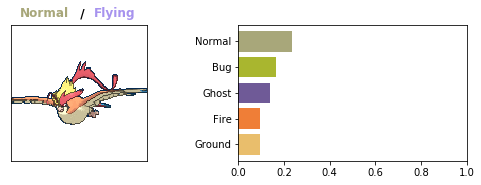

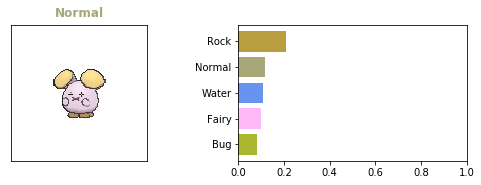

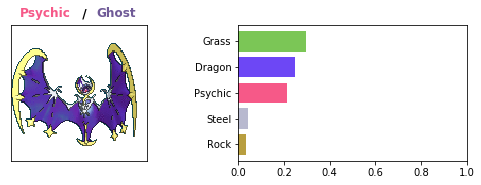

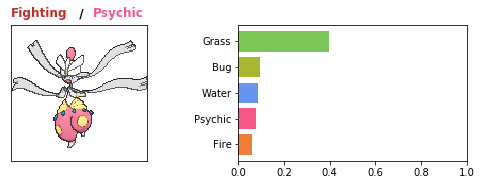

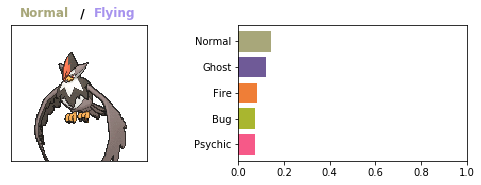

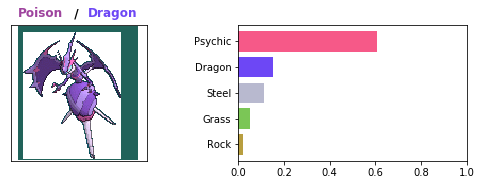

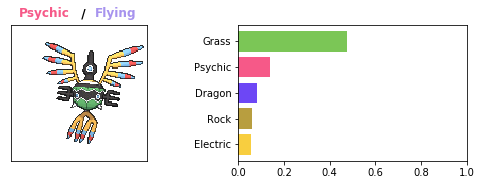

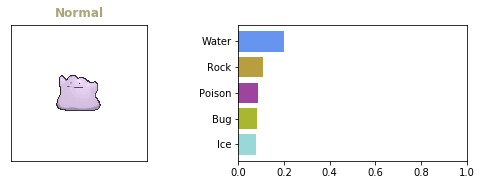

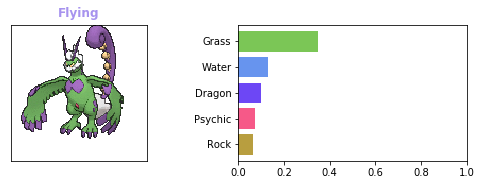

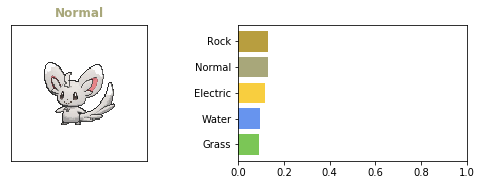

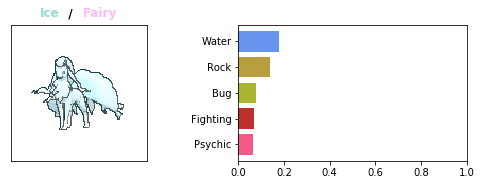

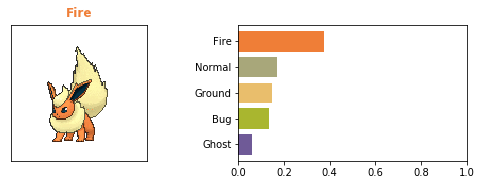

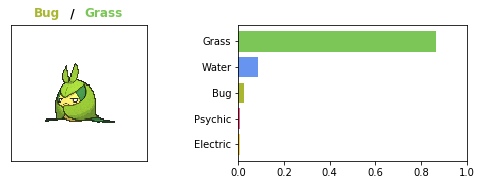

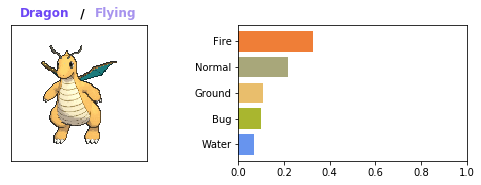

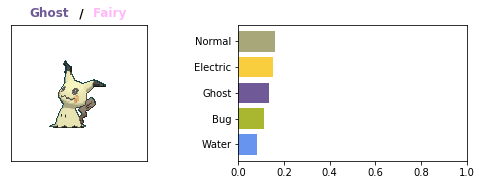

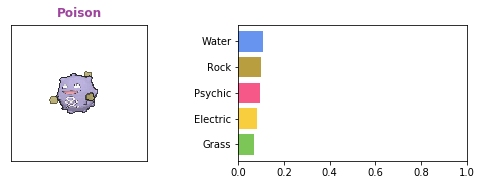

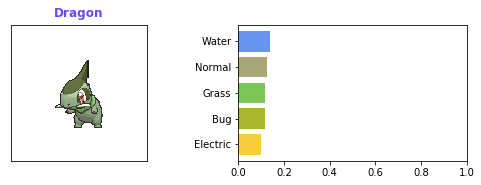

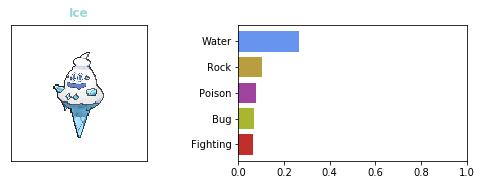

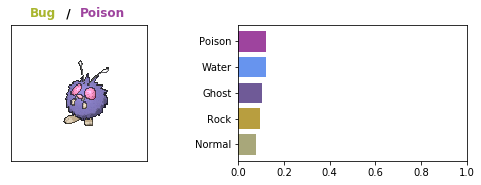

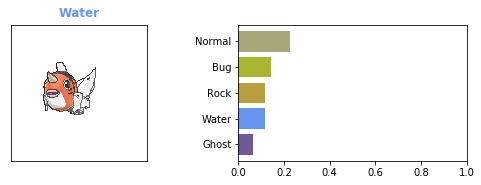

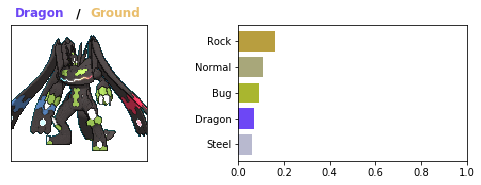

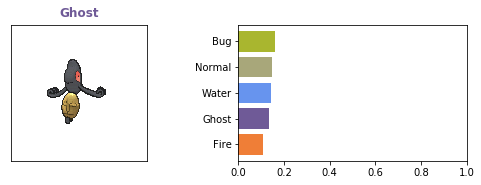

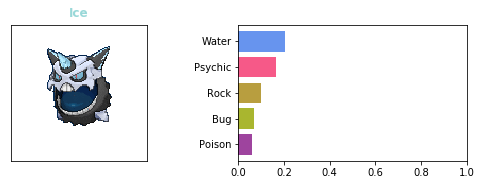

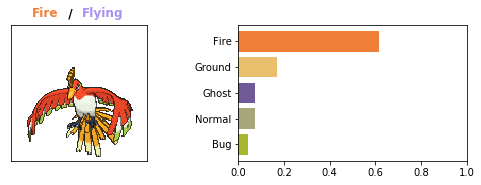

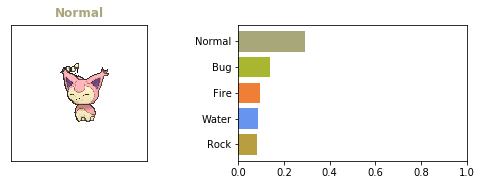

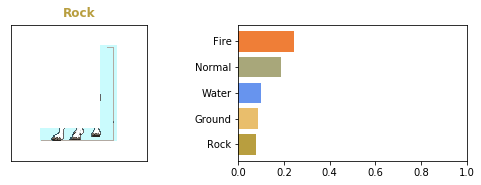

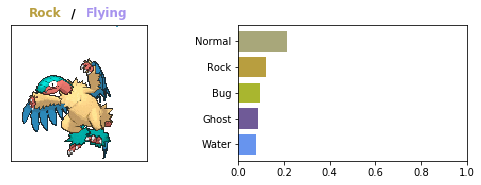

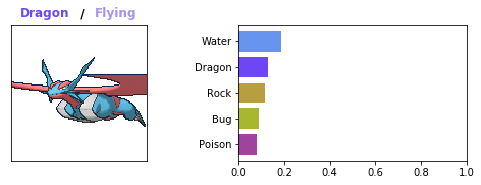

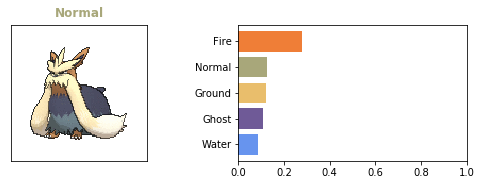

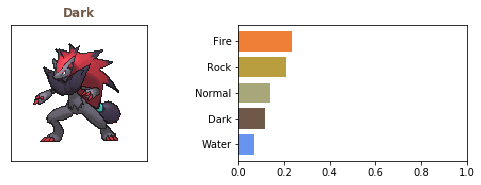

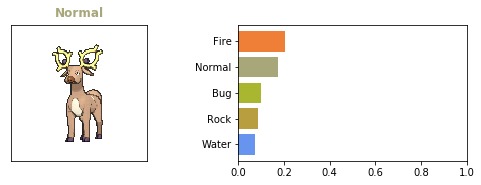

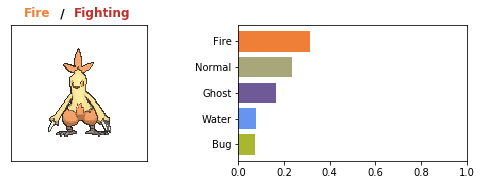

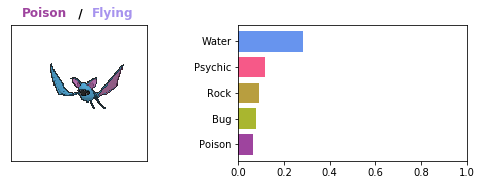

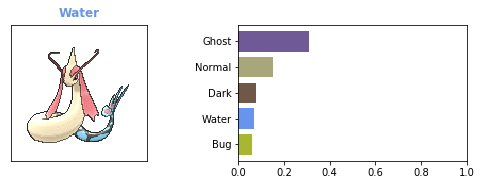

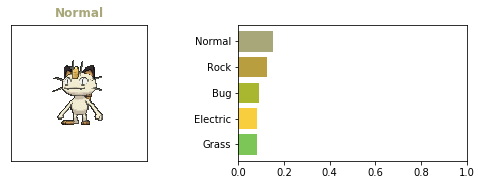

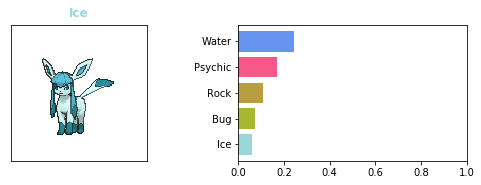

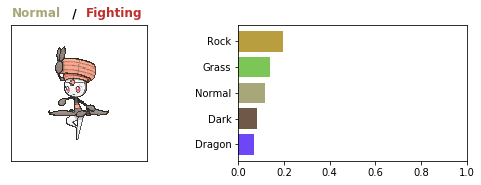

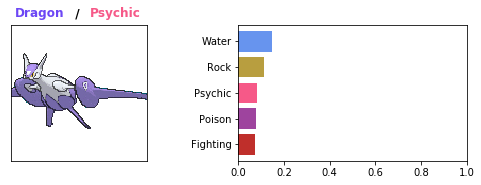

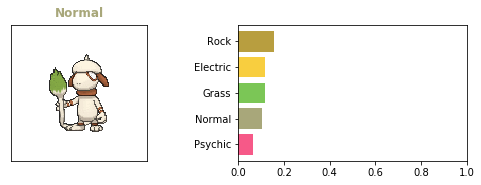

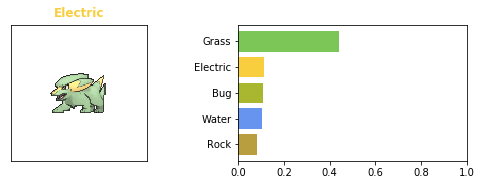

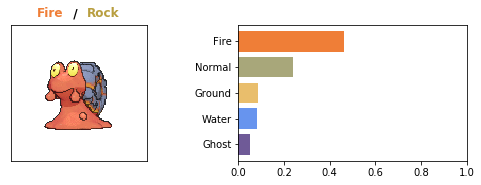

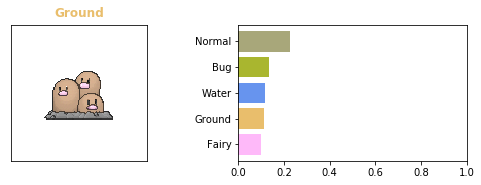

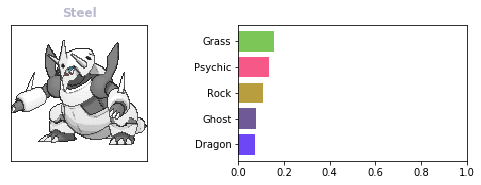

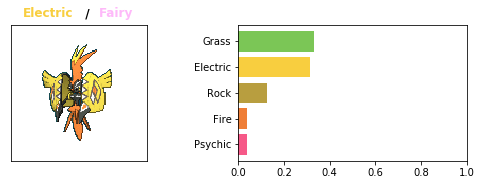

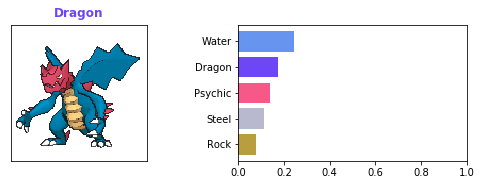

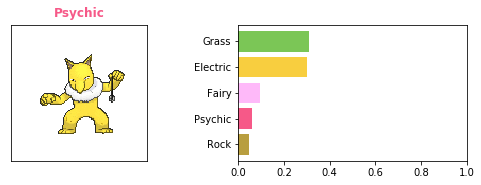

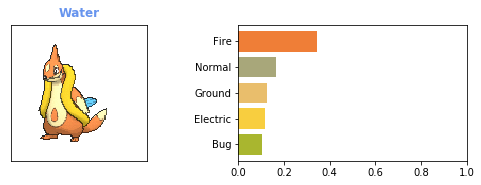

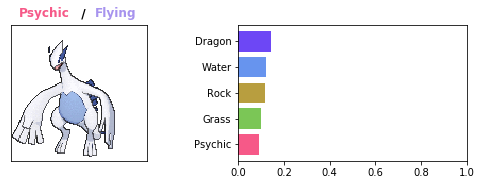

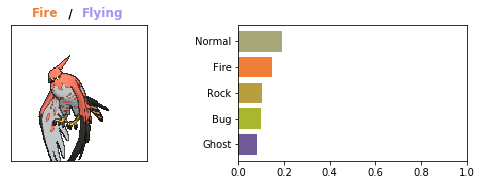

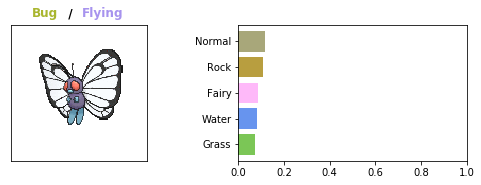

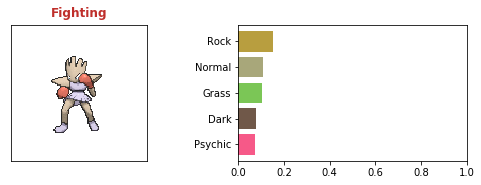

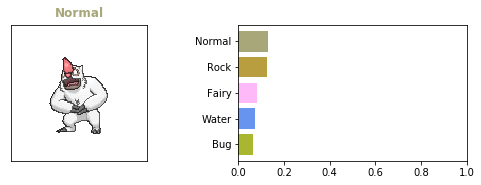

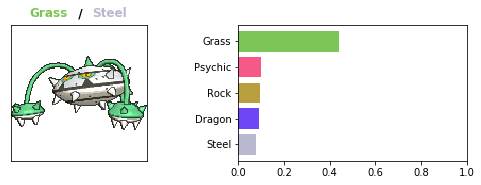

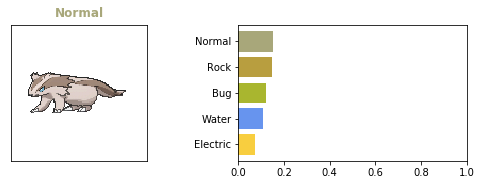

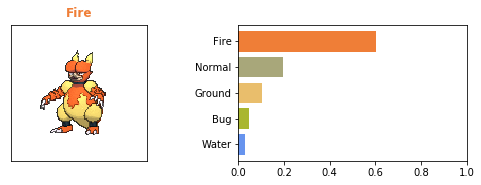

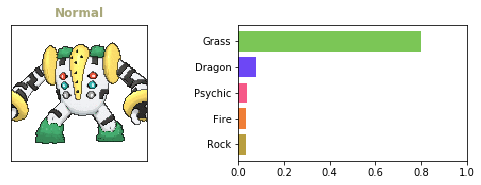

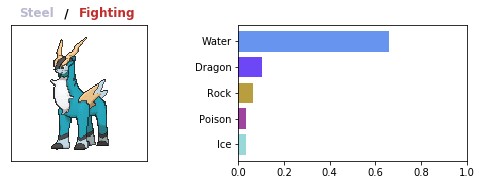

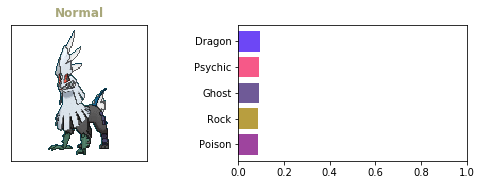

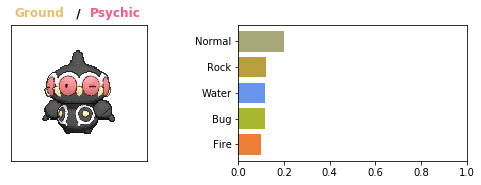

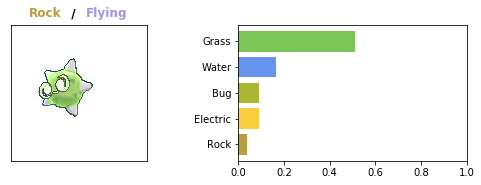

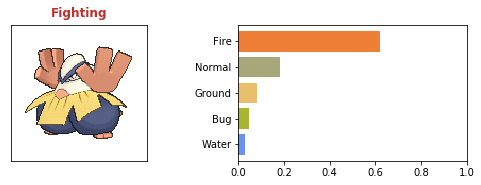

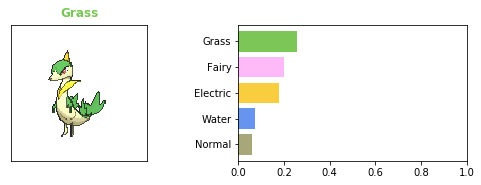

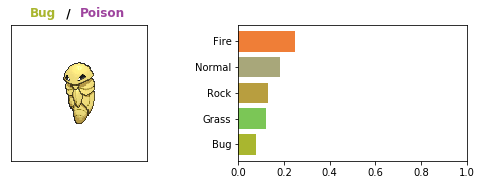

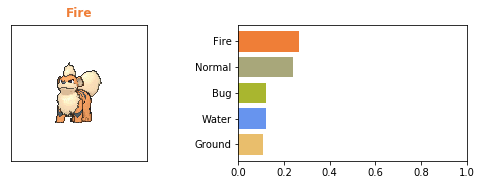

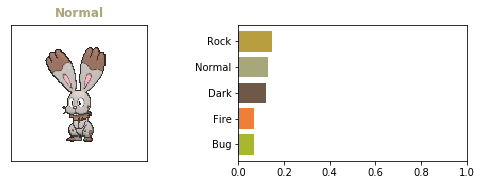

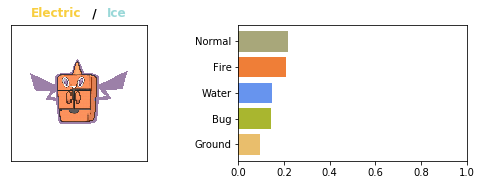

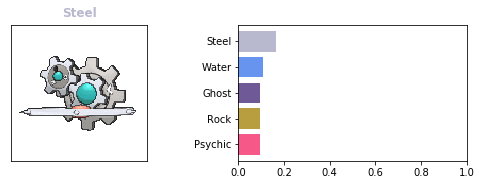

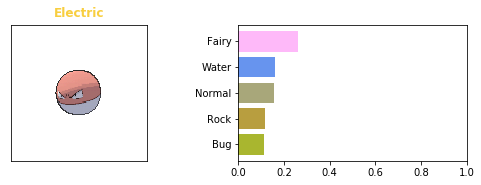

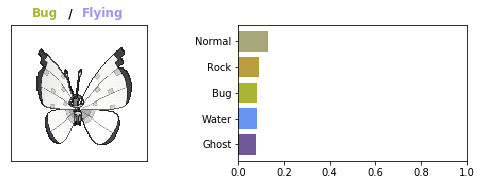

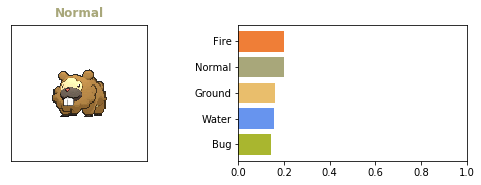

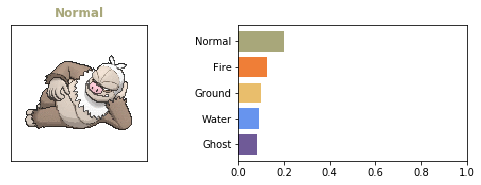

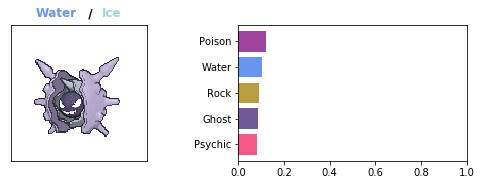

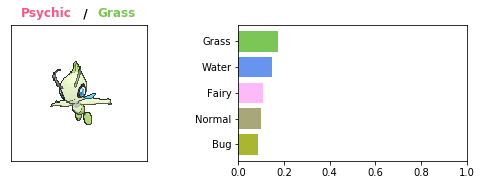

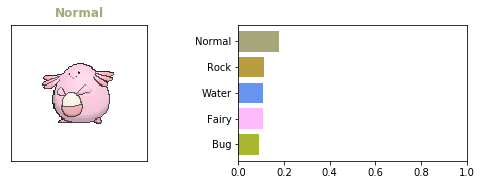

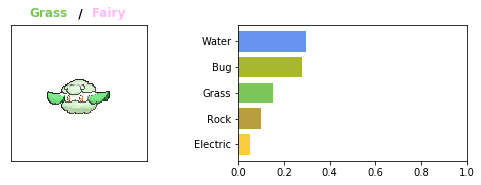

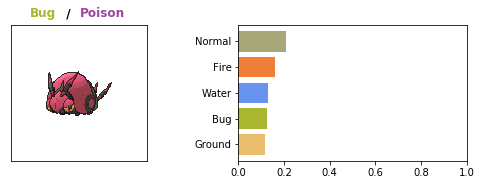

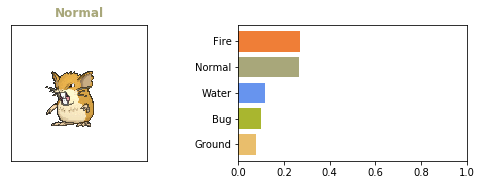

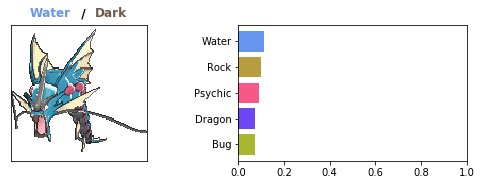

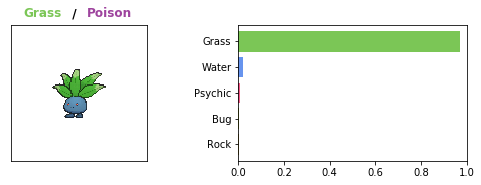

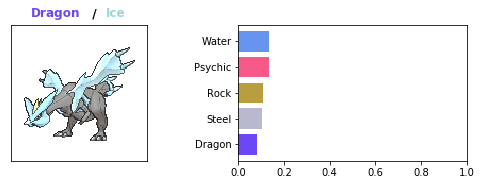

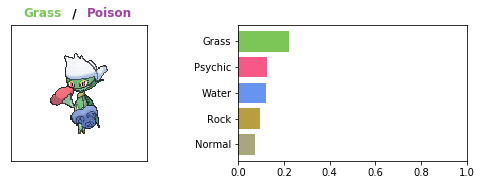

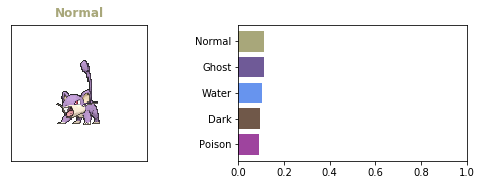

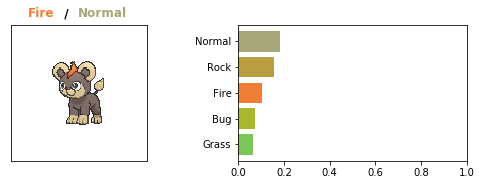

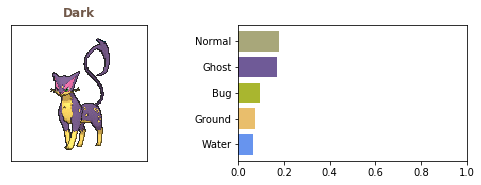

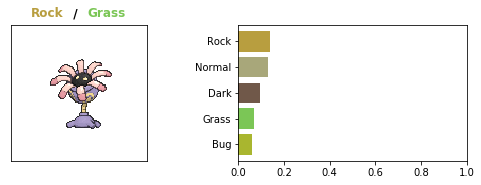

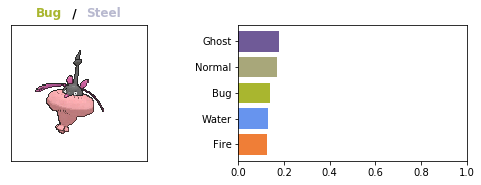

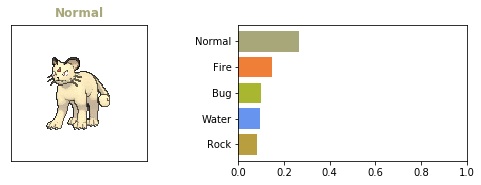

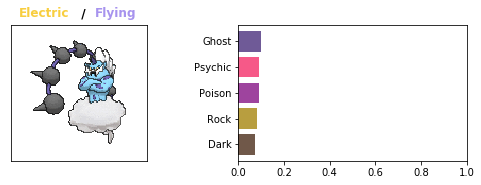

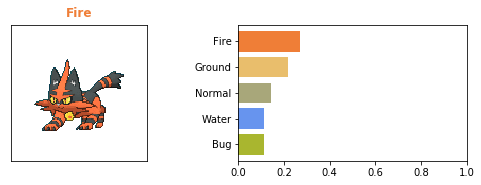

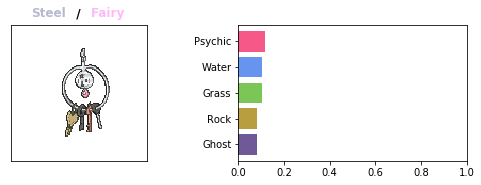

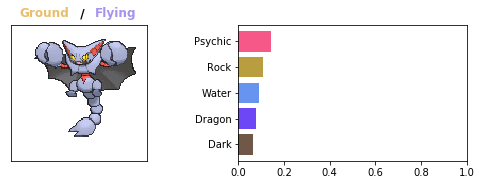

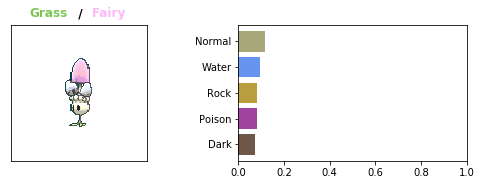

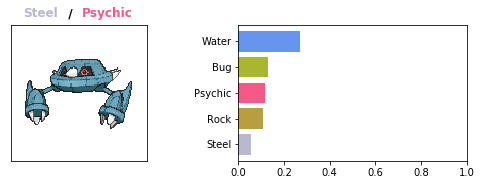

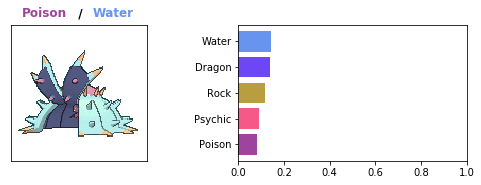

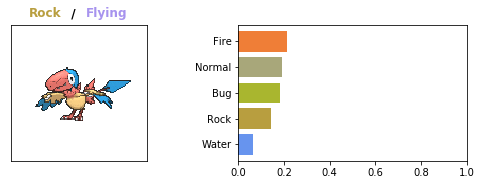

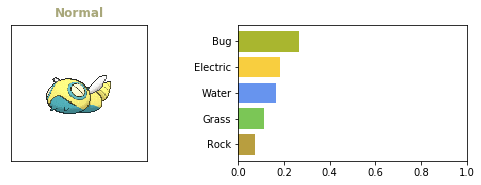

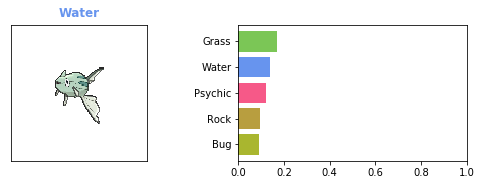

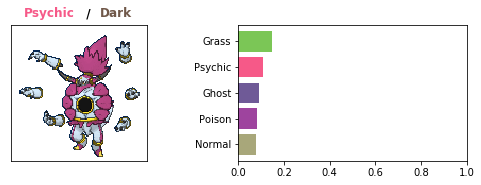

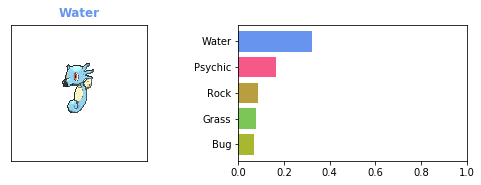

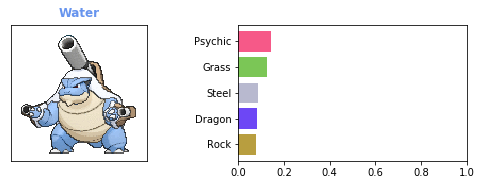

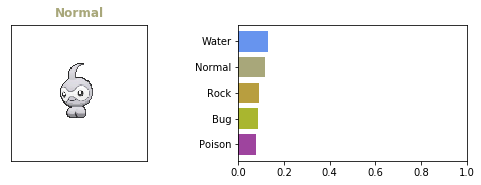

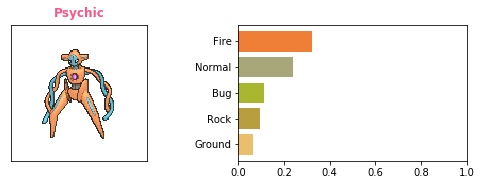

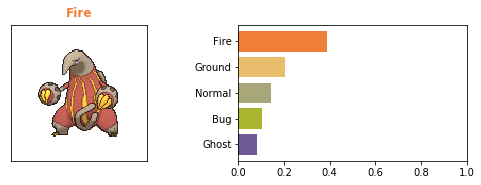

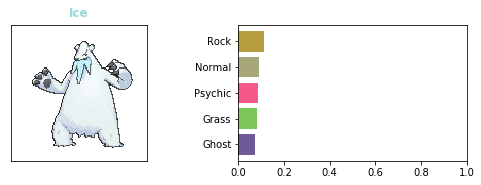

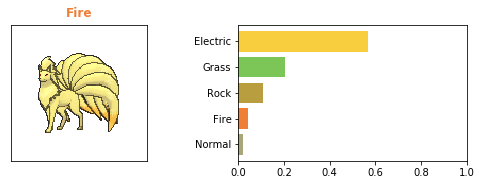

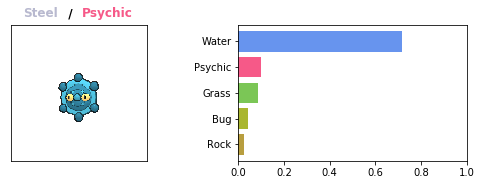

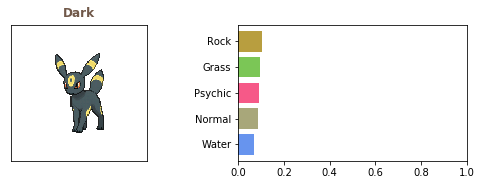

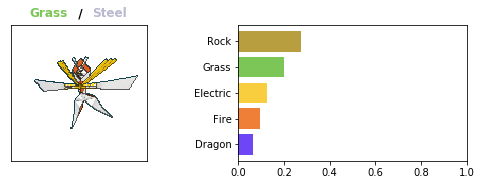

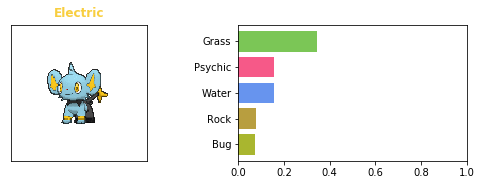

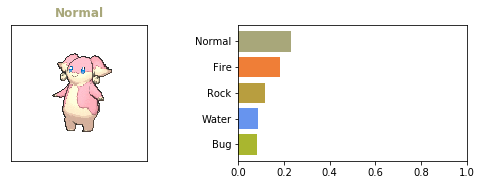

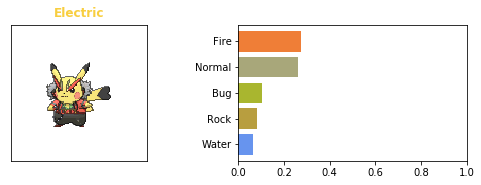

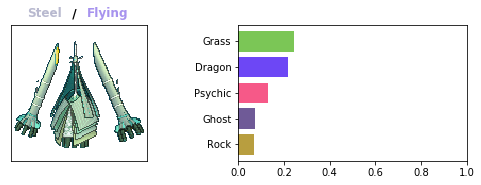

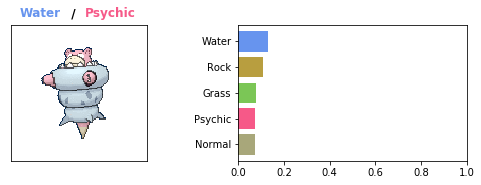

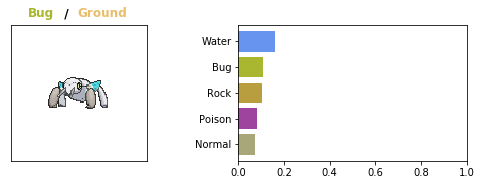

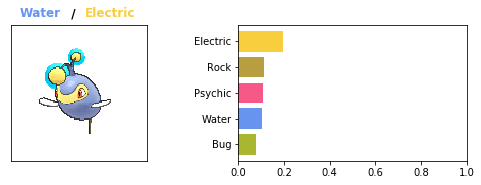

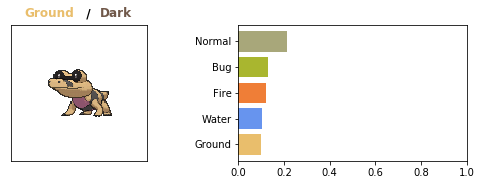

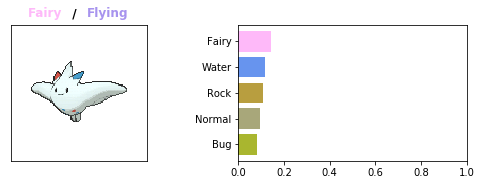

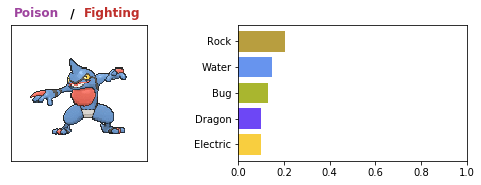

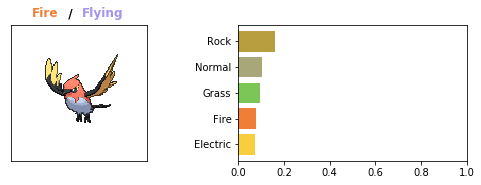

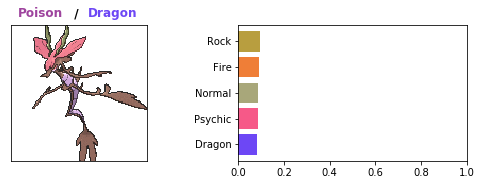

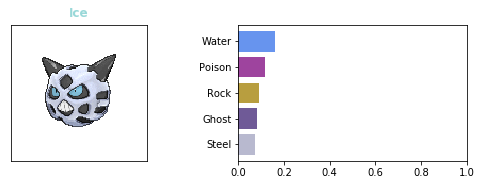

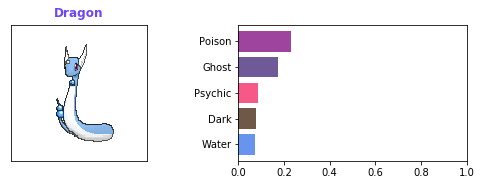

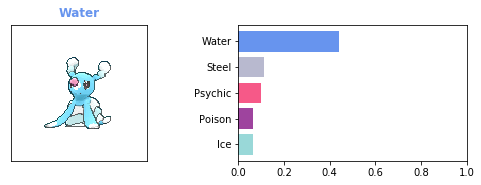

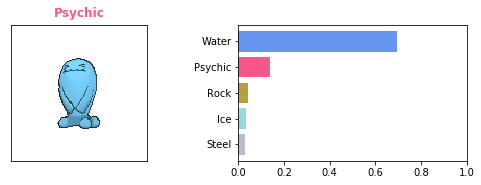

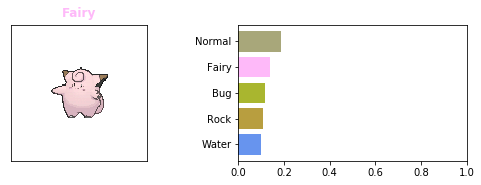

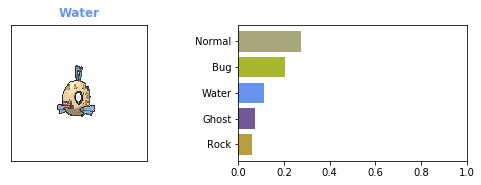

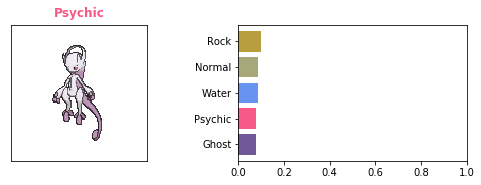

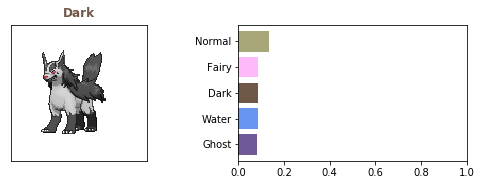

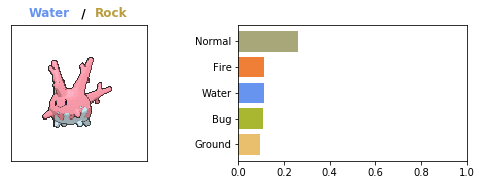

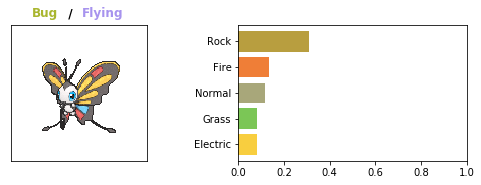

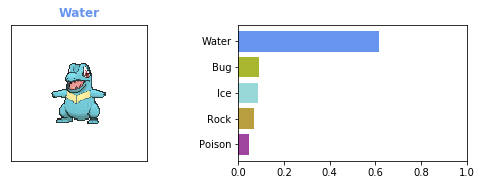

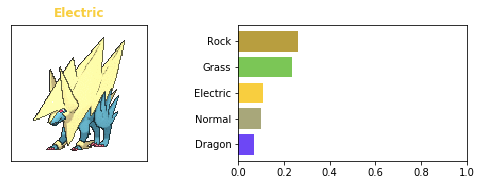

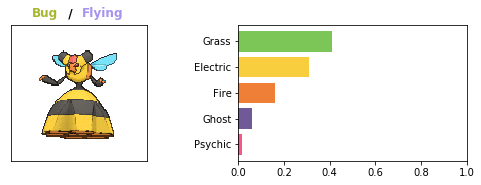

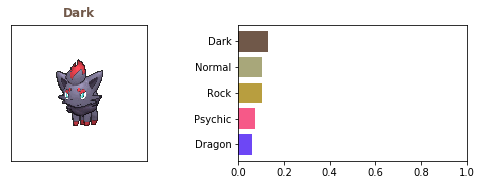

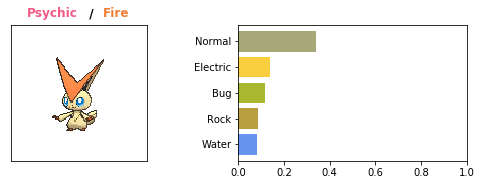

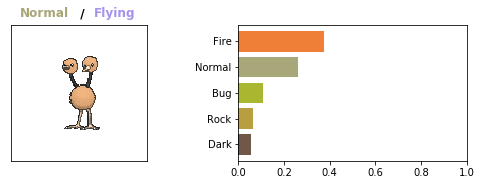

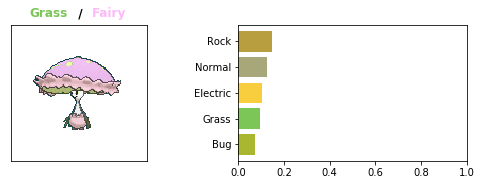

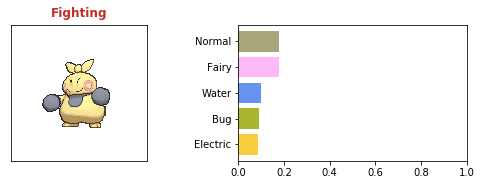

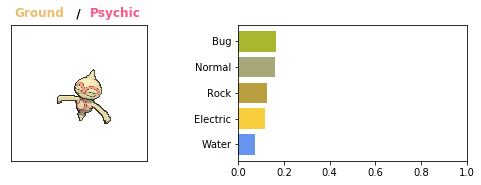

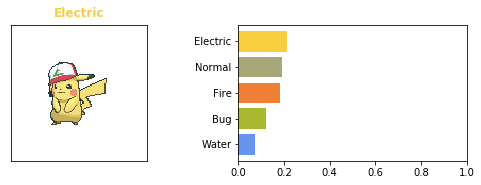

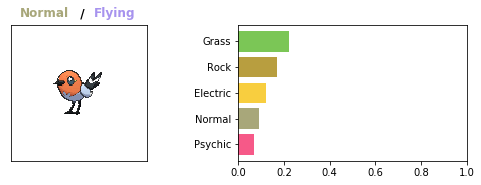

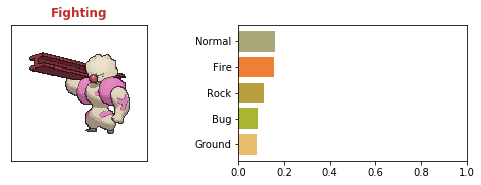

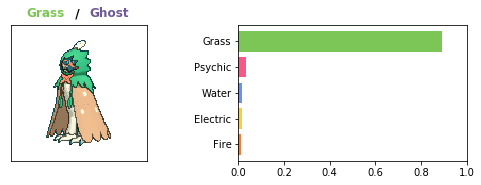

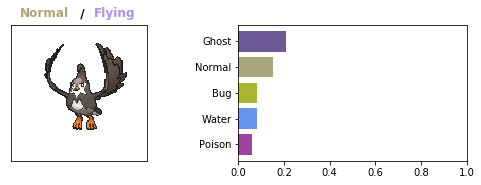

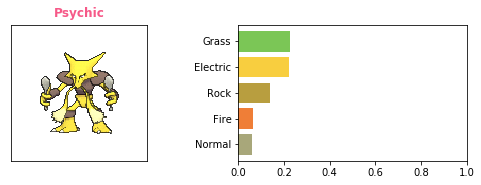

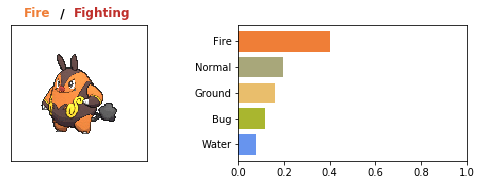

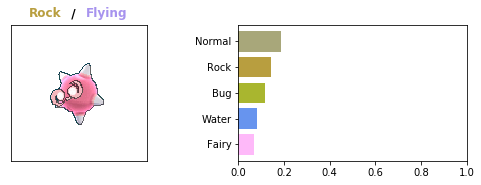

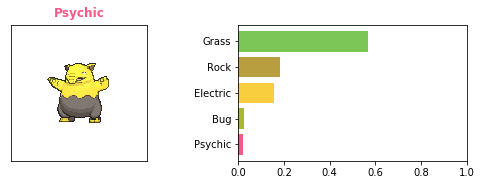

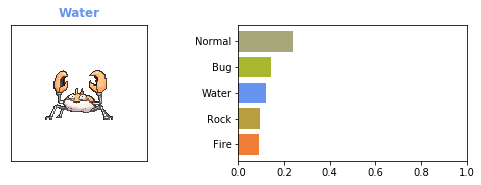

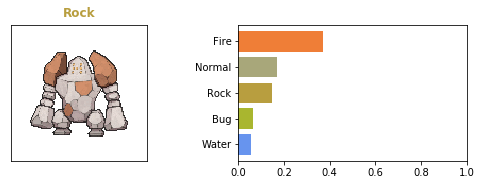

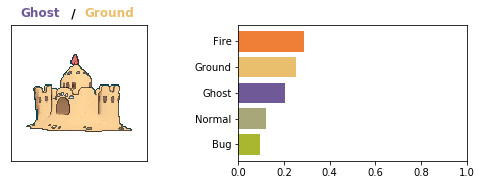

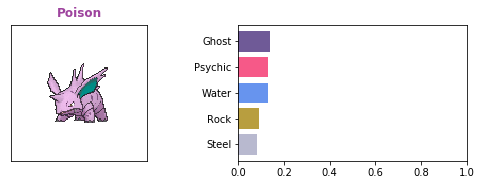

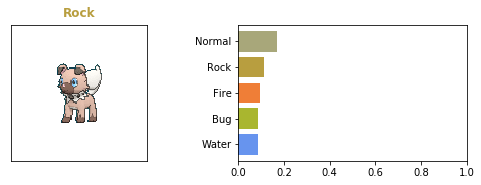

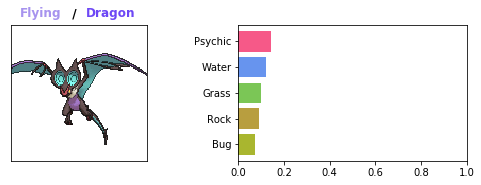

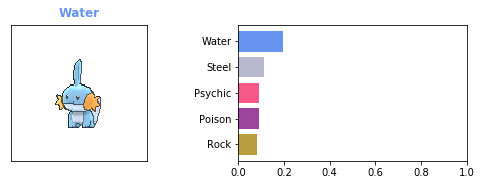

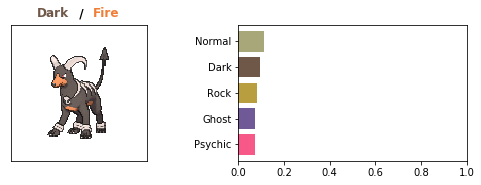

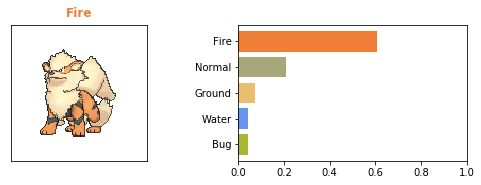

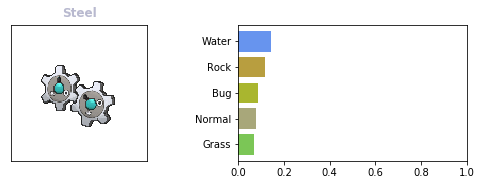

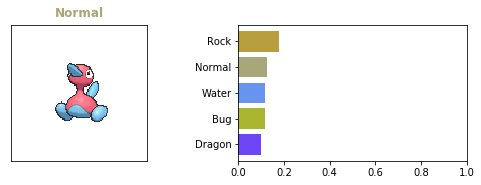

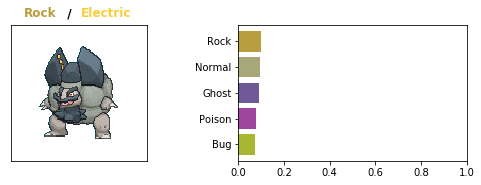

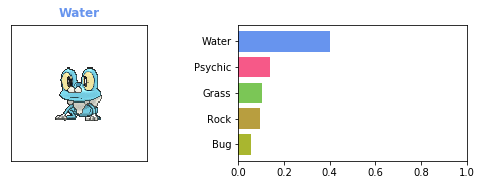

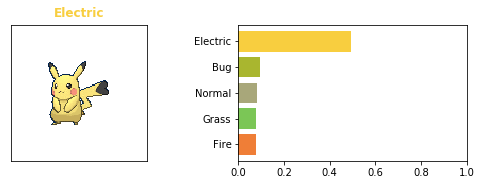

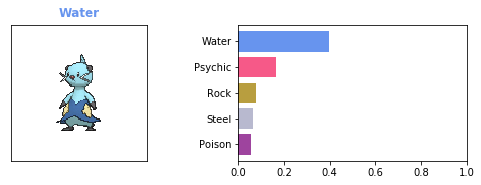

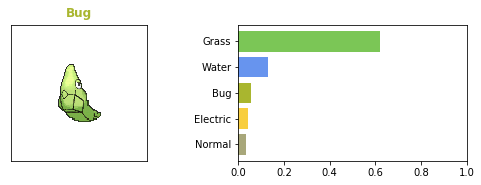

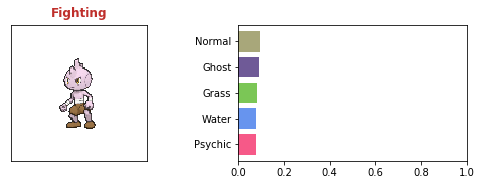

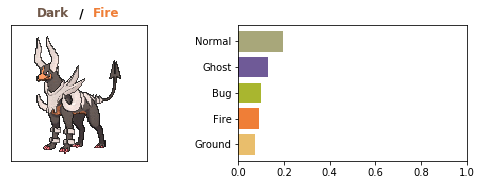

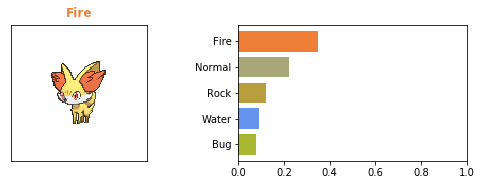

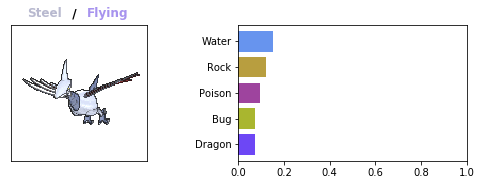

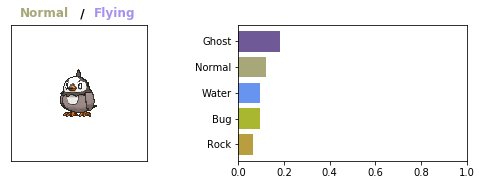

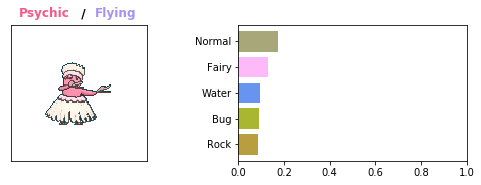

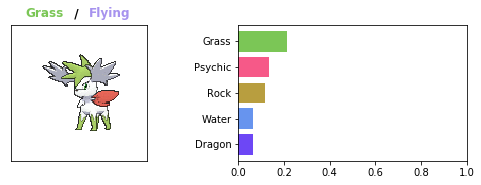

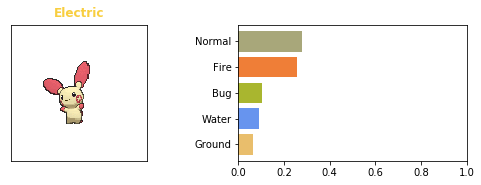

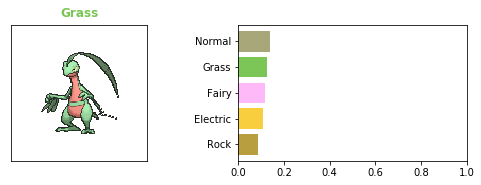

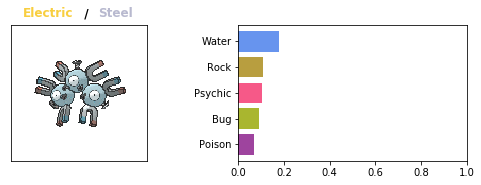

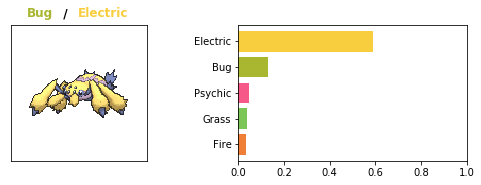

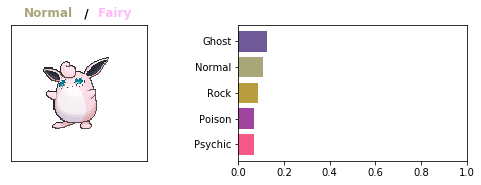

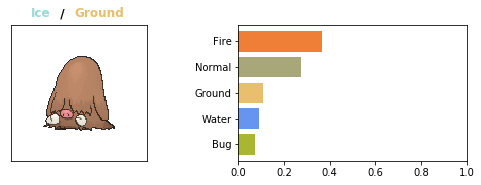

In [61]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Test predictions")
pp.plotPredictions(x_test_i[start*step:(start+num)*step:step],
                   y_test_m[start*step:(start+num)*step:step],
                   test_avg_scores[start:start+num:1], k=5, y2=y_test_2[start*step:(start+num)*step:step])

In [37]:
drops = []
regs = []
histories = []

# Test levels of regularization
for i in range(20):
    print()
    print("> Iteration", i+1)
    r = np.random.uniform(-5,-1)
    d = np.random.uniform(np.log10(0.1),np.log10(0.99))
    reg = 10**r
    drop = 10**d
    model = getInitialModel(False, reg=reg, drop=drop, downsample=2)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history = model.fit_generator(
        data_aug.flow(x_train_d, oneHot(y_train_d, 18), batch_size=64),
        epochs=5,
        verbose=1,
        validation_data=(x_val_d, oneHot(y_val_d, 18)),
    )
    drops.append(drop)
    regs.append(reg)
    histories.append(history.history)


> Iteration 1
Model params: drop = 0.17266978391437238 , reg = 9.235865753666159e-05
Epoch 1/5
47/47 [==============================] - 25s 543ms/step - loss: 2.7173 - acc: 0.1467 - val_loss: 2.7729 - val_acc: 0.1788
Epoch 2/5
47/47 [==============================] - 25s 523ms/step - loss: 2.5880 - acc: 0.1964 - val_loss: 2.6738 - val_acc: 0.1815
Epoch 3/5
47/47 [==============================] - 24s 521ms/step - loss: 2.5070 - acc: 0.2202 - val_loss: 2.6608 - val_acc: 0.1907
Epoch 4/5
47/47 [==============================] - 24s 518ms/step - loss: 2.4014 - acc: 0.2463 - val_loss: 2.6261 - val_acc: 0.1748
Epoch 5/5
47/47 [==============================] - 24s 517ms/step - loss: 2.3264 - acc: 0.2762 - val_loss: 2.6320 - val_acc: 0.2199

> Iteration 2
Model params: drop = 0.13721594685009414 , reg = 0.010375958618200886
Epoch 1/5
47/47 [==============================] - 26s 543ms/step - loss: 3.6379 - acc: 0.1434 - val_loss: 3.3068 - val_acc: 0.1629
Epoch 2/5
47/47 [====================


> Iteration 12
Model params: drop = 0.3827181965595346 , reg = 0.007078686251598595
Epoch 1/5
47/47 [==============================] - 25s 535ms/step - loss: 3.4722 - acc: 0.1295 - val_loss: 3.0753 - val_acc: 0.1457
Epoch 2/5
47/47 [==============================] - 24s 500ms/step - loss: 2.9134 - acc: 0.1887 - val_loss: 2.9232 - val_acc: 0.1828
Epoch 3/5
47/47 [==============================] - 23s 498ms/step - loss: 2.7805 - acc: 0.1976 - val_loss: 2.8755 - val_acc: 0.1762
Epoch 4/5
47/47 [==============================] - 23s 499ms/step - loss: 2.6861 - acc: 0.2130 - val_loss: 2.8152 - val_acc: 0.2053
Epoch 5/5
47/47 [==============================] - 23s 499ms/step - loss: 2.6385 - acc: 0.2310 - val_loss: 2.8149 - val_acc: 0.2066

> Iteration 13
Model params: drop = 0.14509240996289582 , reg = 0.004247137549681021
Epoch 1/5
47/47 [==============================] - 25s 538ms/step - loss: 3.1912 - acc: 0.1570 - val_loss: 3.0192 - val_acc: 0.1444
Epoch 2/5
47/47 [====================

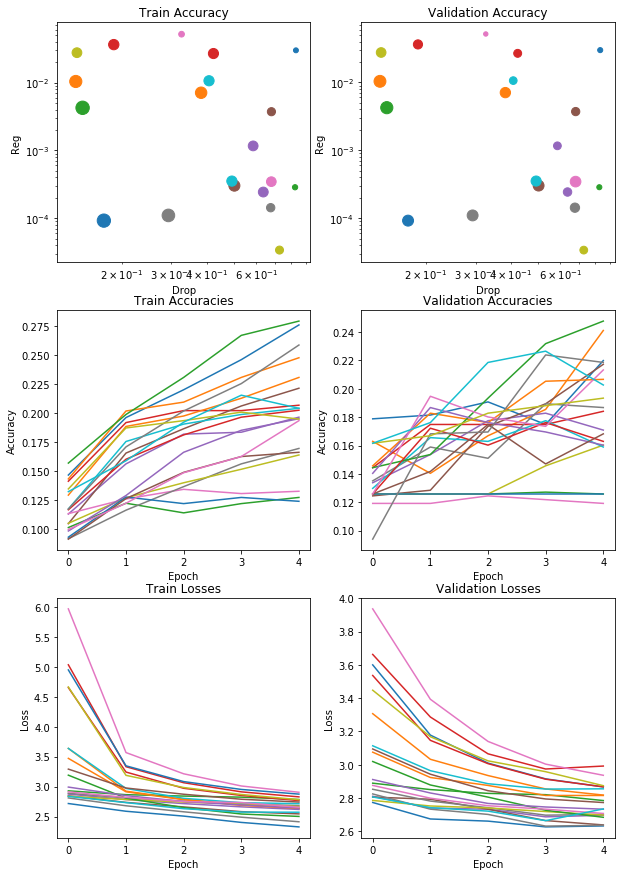

In [43]:
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3,2)

for i in range(2):
    t = None
    accs = None
    losses = None
    if i == 0:
        t = "Train"
        accs = np.array([histories[i]['acc'] for i in range(len(histories))])
        losses = np.array([histories[i]['loss'] for i in range(len(histories))])
    else:
        t = "Validation"
        accs = np.array([histories[i]['val_acc'] for i in range(len(histories))])
        losses = np.array([histories[i]['val_loss'] for i in range(len(histories))])
                
    ax = plt.subplot(gs[i])
    ax.set_title(t + " Accuracy")
    ax.set_xlabel("Drop")
    ax.set_xscale('log')
    ax.set_ylabel("Reg")
    ax.set_yscale('log')
    colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
    c = [colors[i%len(colors)] for i in range(accs.shape[0])]
    nepochs = accs.shape[1]
    ax.scatter(np.array(drops), np.array(regs), s=(accs[:,nepochs-1]-0.1)*1e3, c=c)
    
    ax2 = plt.subplot(gs[i+2])
    ax2.set_title(t + " Accuracies")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(accs.T)
    
    ax3 = plt.subplot(gs[i+4])
    ax3.set_title(t + " Losses")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Loss")
    ax3.plot(losses.T)

plt.show()